In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
from sklearn import datasets
from sklearn.metrics import roc_auc_score
import numbers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import accuracy_score, r2_score
import seaborn as sns
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION, DATASET_PATH
from imodels.util.data_util import get_clean_dataset
import os
from datetime import datetime
import pickle
from tqdm import tqdm, trange
from sklearn.datasets import make_friedman1
from matplotlib.cm import ScalarMappable
from copy import deepcopy

In [3]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [4]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_shrink_mult_analysis")

# Distribution of shrinkage multipliers

## AugHS smSHAP

### Strobl dataset

#### Create dataset

In [4]:
def simulate_data_strobl(n=120, # number of rows in data
                         M=10, # number of simulations
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n,M))
    x2 = random_state.randint(1, 3, size=(n,M))
    x3 = random_state.randint(1, 5, size=(n,M))
    x4 = random_state.randint(1, 11, size=(n,M))
    x5 = random_state.randint(1, 21, size=(n,M))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* relevance))

    return X, y

In [5]:
#Null simulation
X_nulls, y_nulls = simulate_data_strobl(n=120, M=100, relevance=0, seed=42)
#Power simulation
X_powers, y_powers = simulate_data_strobl(n=120, M=100, relevance=0.15, seed=42)

#### Fit models and store smoothing coefficients

In [9]:
# Fit models and compute smooth shap values and coefs
null_smSHAP_vals = []
null_smSHAP_coefs = []
power_smSHAP_vals = []
power_smSHAP_coefs = []

for i in trange(X_nulls.shape[0]):
    clf_null = RandomForest(n_trees=25, n_feature="sqrt", treetype="classification", oob=True , oob_SHAP=True, random_state=None)
    clf_null.fit(X_nulls[i,:,:], y_nulls[:,i])
    shap_values_null_inbag = clf_null.inbag_SHAP_values
    shap_values_null_oob = clf_null.oob_SHAP_values
    smshap_vals_null, _, smshap_coefs_null = smooth_shap(shap_values_null_inbag, shap_values_null_oob)
    null_smSHAP_vals.append(smshap_vals_null)
    null_smSHAP_coefs.append(smshap_coefs_null)

    clf_power = RandomForest(n_trees=25, n_feature="sqrt", treetype="classification", oob=True , oob_SHAP=True, random_state=None)
    clf_power.fit(X_powers[i,:,:], y_powers[:,i])
    shap_values_power_inbag = clf_power.inbag_SHAP_values
    shap_values_power_oob = clf_power.oob_SHAP_values
    smshap_vals_power, _, smshap_coefs_power = smooth_shap(shap_values_power_inbag, shap_values_power_oob)
    power_smSHAP_vals.append(smshap_vals_power)
    power_smSHAP_coefs.append(smshap_coefs_power)

100%|██████████| 100/100 [07:22<00:00,  4.42s/it]


In [64]:
# store simulation results as pickle file
dset_name = "strobl"
data = [null_smSHAP_vals, null_smSHAP_coefs, power_smSHAP_vals, power_smSHAP_coefs]

with open(f'{data_path}/AugHSsmSH_{dset_name}_results.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Plot mean abs. SHAP value distribution

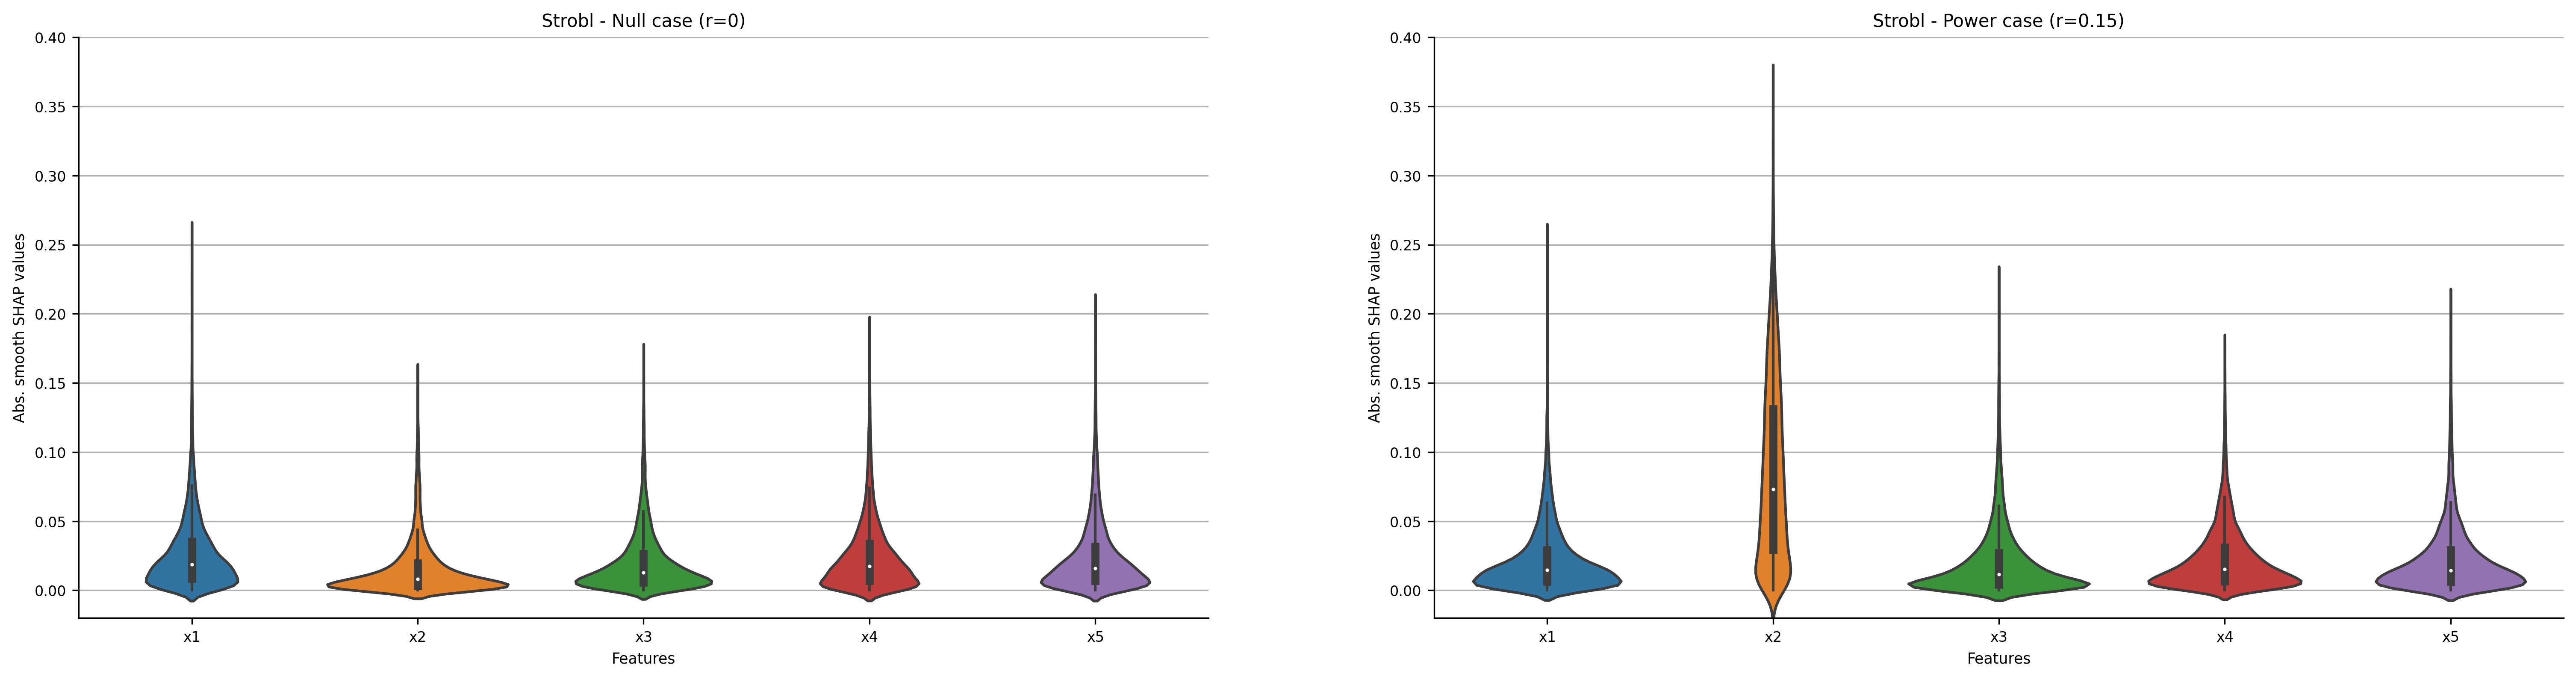

In [17]:
# Check distribution of absolute smooth SHAP values per feature accross the different models
fig, axs = plt.subplots(1,2,figsize=(25,6))

# create dataframes for plotting with
# seaborn
null_smSHAP_vals_df = pd.DataFrame(np.abs(null_smSHAP_vals).reshape(12000,5), columns=["x1","x2","x3","x4","x5"]).melt()
power_smSHAP_vals_df = pd.DataFrame(np.abs(power_smSHAP_vals).reshape(12000,5), columns=["x1","x2","x3","x4","x5"]).melt()

n = sns.violinplot(x="variable", y="value", data=null_smSHAP_vals_df, ax=axs[0])
p = sns.violinplot(x="variable", y="value", data=power_smSHAP_vals_df, ax=axs[1])


for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    if i==0:
        ax.set_title(f"Strobl - Null case (r=0)", fontsize="medium")
    else:
        ax.set_title(f"Strobl - Power case (r=0.15)", fontsize="medium")
    ax.set_xlabel("Features", fontsize="small")
    ax.set_ylabel("Abs. smooth SHAP values", fontsize="small")
    ax.set_axisbelow(True)
    ax.grid(axis="y")
    for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(8);

plt.setp(axs, ylim=[-0.02,0.4]); #set global ylim for all suplots

#### Plot SHAP coef. distribution

In [21]:
#Set coefficients which are smaller than 0 to zero and higher than 1 to 1
null_smSHAP_coefs_arr = np.array(null_smSHAP_coefs)
null_smSHAP_coefs_arr[null_smSHAP_coefs_arr<0]=0
null_smSHAP_coefs_arr[null_smSHAP_coefs_arr>1]=1

power_smSHAP_coefs_arr = np.array(power_smSHAP_coefs)
power_smSHAP_coefs_arr[power_smSHAP_coefs_arr<0]=0
power_smSHAP_coefs_arr[power_smSHAP_coefs_arr>1]=1

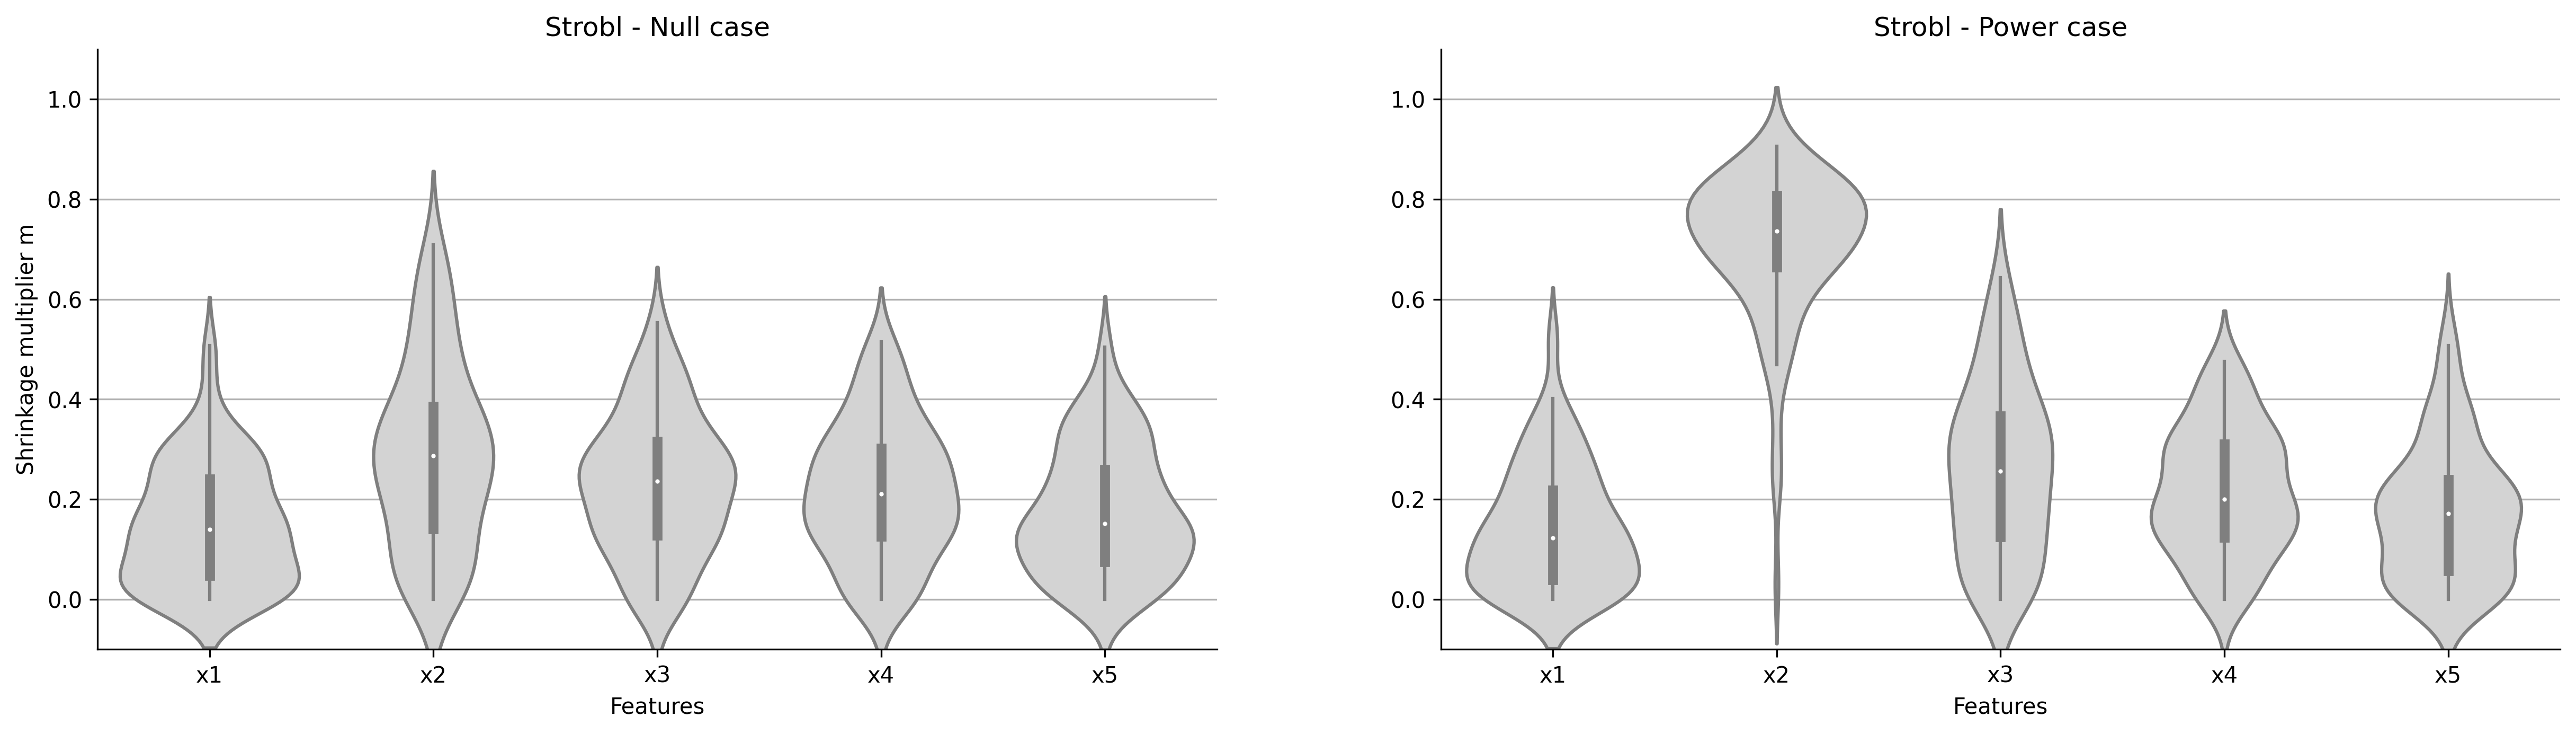

In [174]:
# Check distribution of smooth SHAP coefficients per feature accross the different models
fig, axs = plt.subplots(1,2,figsize=(20,5))

# create dataframes for plotting with seaborn
null_smSHAP_coefs_df = pd.DataFrame(np.abs(null_smSHAP_coefs_arr), columns=["x1","x2","x3","x4","x5"]).melt()
power_smSHAP_coefs_df = pd.DataFrame(np.abs(power_smSHAP_coefs_arr), columns=["x1","x2","x3","x4","x5"]).melt()

n = sns.violinplot(x="variable", y="value", data=null_smSHAP_coefs_df, ax=axs[0], color="lightgray")
p = sns.violinplot(x="variable", y="value", data=power_smSHAP_coefs_df, ax=axs[1], color="lightgray")


for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    if i==0:
        ax.set_title(f"Strobl - Null case")
    else:
        ax.set_title(f"Strobl - Power case")
    ax.set_xlabel("Features")
    if i==0:
        ax.set_ylabel("Shrinkage multiplier m")
    else:
        ax.set_ylabel("")
    ax.set_axisbelow(True)
    ax.grid(axis="y")
    #for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(8);
    
plt.setp(axs, ylim=[-0.1,1.1]); #set global ylim for all suplots


In [175]:
dset_name = "strobl"
filename = f"AugHSsmSH_{dset_name}_coef_dist_violinplot"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

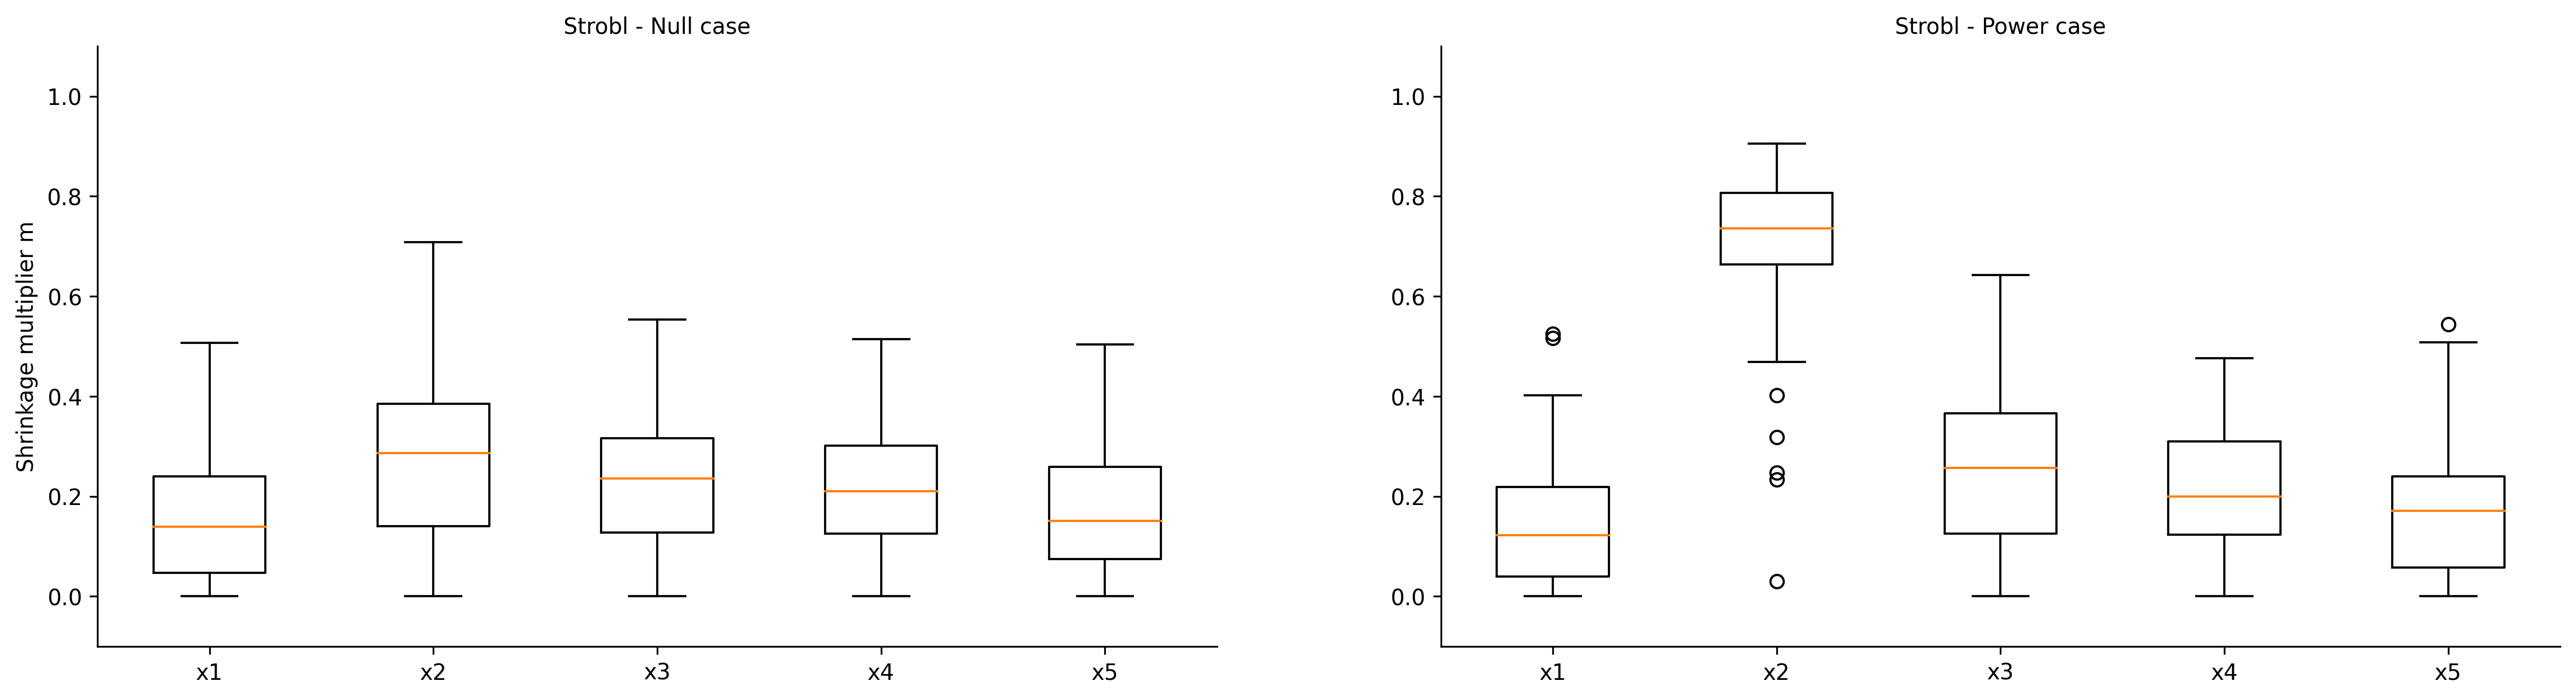

In [170]:
# Check distribution of smooth SHAP coefficients per feature accross the different models
fig, axs = plt.subplots(1,2,figsize=(20,5))

x_labels = ["x1","x2","x3","x4","x5"]
axs[0].boxplot(null_smSHAP_coefs_arr, labels=x_labels)
axs[1].boxplot(power_smSHAP_coefs_arr, labels=x_labels)


axs[0].set_title(f"Strobl - Null case", fontsize="medium")
axs[1].set_title(f"Strobl - Power case", fontsize="medium")        
axs[0].set_ylabel("Shrinkage multiplier m")

plt.setp(axs, ylim=[-0.1,1.1]); #set global ylim for all suplots

- Smoothing coefficients even for informative features do not reach 1.
- Smoothing coefficients even for uninformative features do not reach 0.

In [39]:
dset_name = "strobl"
filename = f"AugHSsmSH_{dset_name}_coef_dist"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

#### Analyze slope of Smooth SHAP p. feature for one model

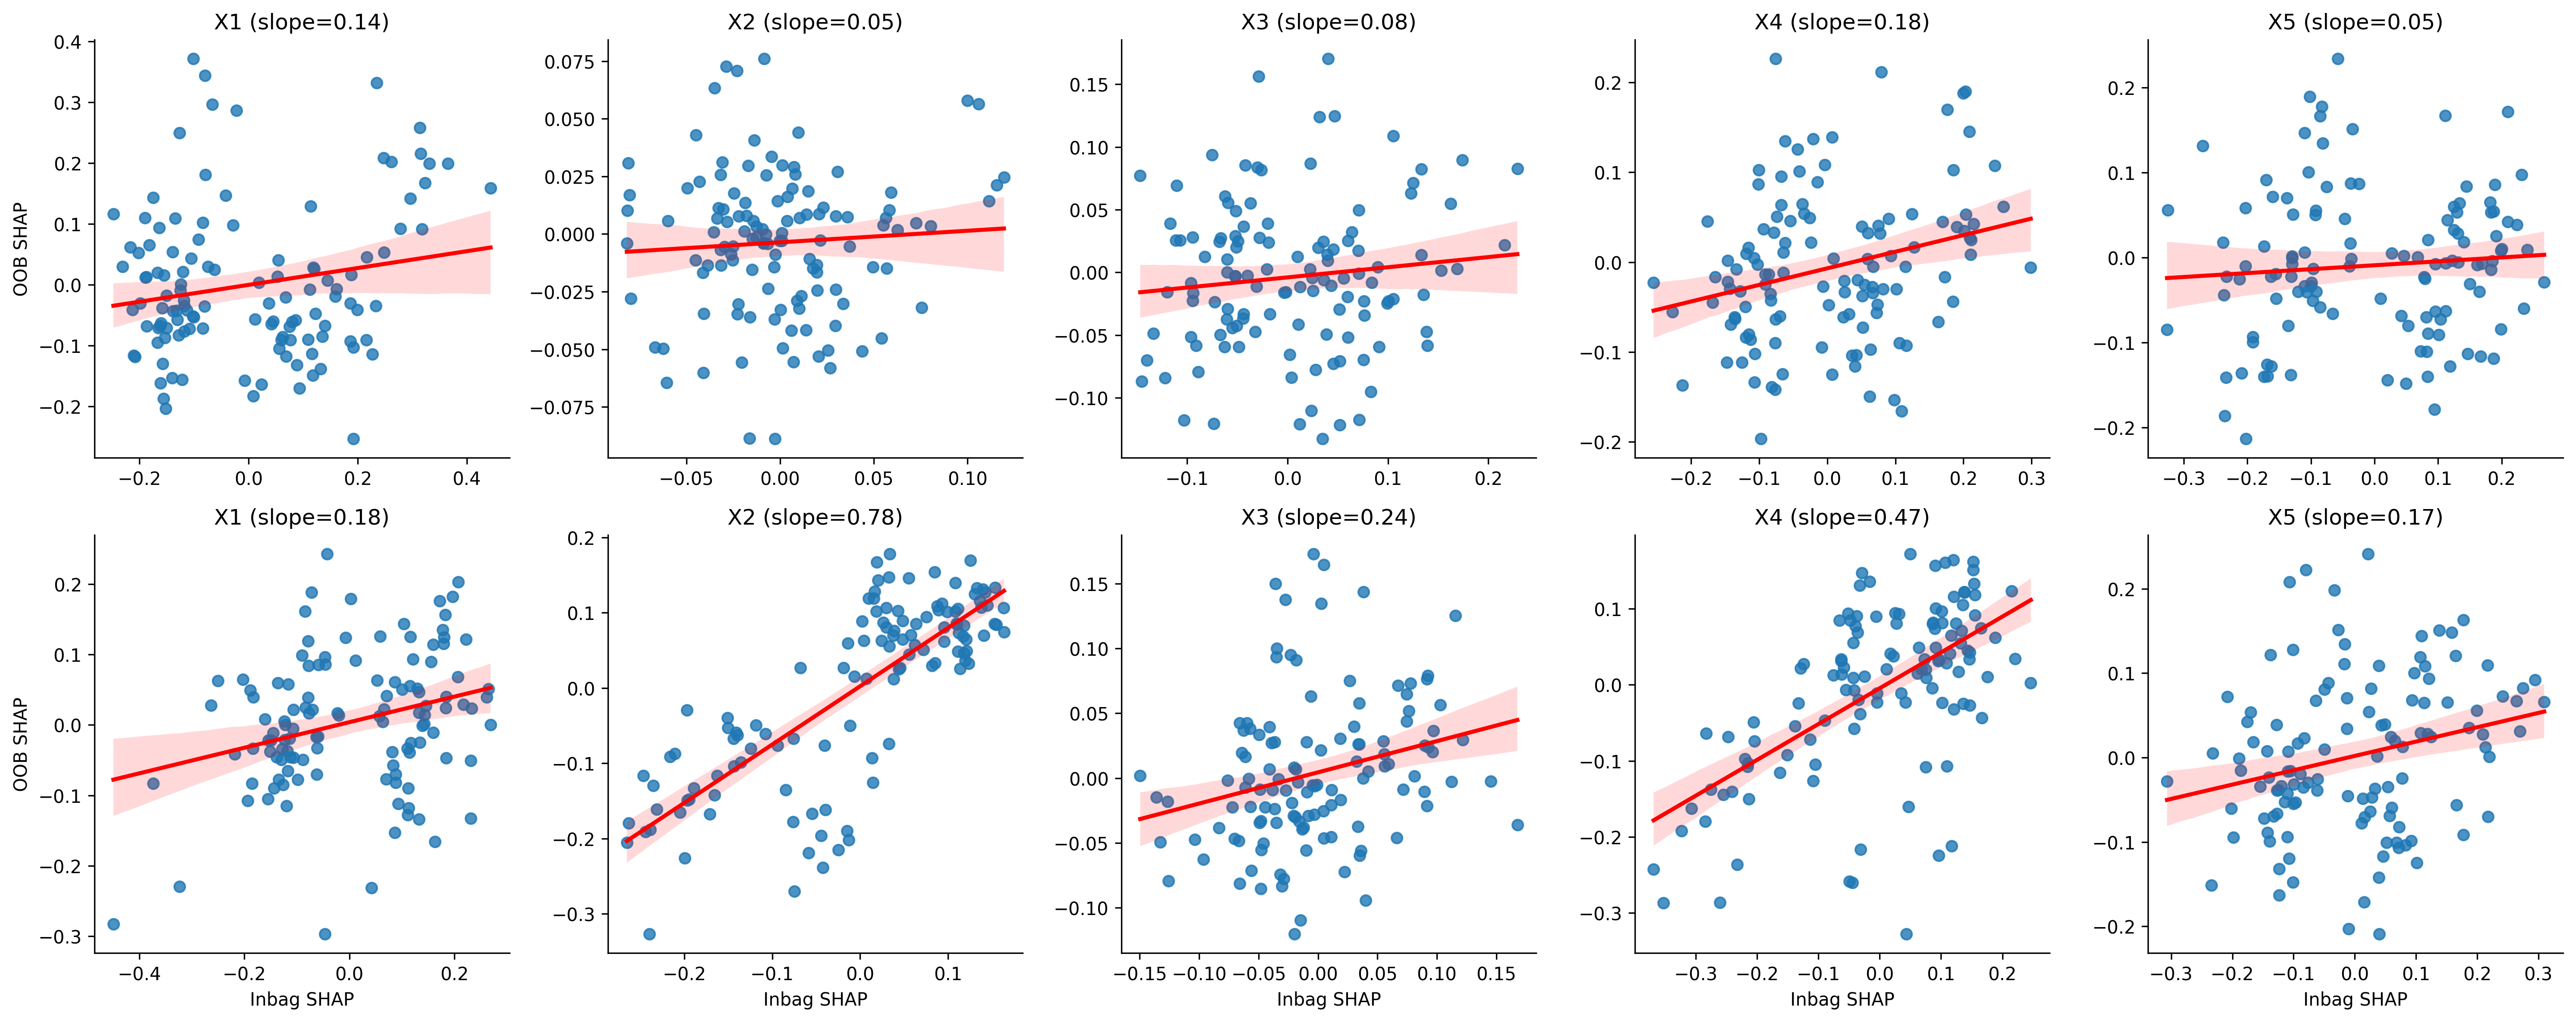

In [54]:
from scipy.stats import linregress
fig, axs2d = plt.subplots(2,5, figsize=(20,8), squeeze=False)
axs = axs2d.flatten()

for i in range(5):
    n = sns.regplot(x=clf_null.inbag_SHAP_values[:, i].reshape(-1, 1), y=clf_null.oob_SHAP_values[:, i], line_kws={"color": "red"}, ax=axs[i])
    slope, intercept, r_value, p_value, std_err = linregress(x=n.get_lines()[0].get_xdata(),y=n.get_lines()[0].get_ydata())
    axs[i].set_title(f"X{i+1} (slope={round(slope,2)})")# - regression coef: {np.round(rf_scr.smSHAP_coefs[i],2)}")
    axs[0].set_ylabel("OOB SHAP")

for i in range(5,10):
    p = sns.regplot(x=clf_power.inbag_SHAP_values[:, i-5].reshape(-1, 1), y=clf_power.oob_SHAP_values[:, i-5], line_kws={"color": "red"}, ax=axs[i])
    slope, intercept, r_value, p_value, std_err = linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    axs[i].set_title(f"X{i-4} (slope={round(slope,2)})")# - regression coef: {np.round(rf_scr.smSHAP_coefs[i],2)}")
    axs[5].set_ylabel("OOB SHAP")
    axs[i].set_xlabel("Inbag SHAP")
    

plt.tight_layout();

In [55]:
dset_name = "strobl"
filename = f"AugHSsmSH_{dset_name}_coef_dist_detailed"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

### Titanic

In [47]:
#Load and clean data
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)
X_titanic = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y_titanic = data["Survived"].astype("float")

We fit a RF model on 25 fold cross validation and store the smooth SHAP coefficients for each fold

In [48]:
# Fit models and store in list
from sklearn.model_selection import KFold

smSHAP_titanic_models=[]

kf = KFold(n_splits=25, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_titanic):
    
    #split data
    X_train, X_test = X_titanic.iloc[train_index], X_titanic.iloc[test_index]
    y_train, y_test = y_titanic.iloc[train_index], y_titanic.iloc[test_index]

    #fit estimator
    rf_titanic_smSH = RandomForest(n_trees=25, HS_lambda=1, treetype="classification", oob=True, oob_SHAP=True, HS_smSHAP=True)     
    rf_titanic_smSH.fit(X_train, y_train)
    smSHAP_titanic_models.append(rf_titanic_smSH)

In [49]:
#Store smooth SHAP coefs
titanic_smSHAP_coefs = []
for model in smSHAP_titanic_models:
    titanic_smSHAP_coefs.append(np.abs(model.smSHAP_coefs))

In [63]:
# store simulation results as pickle file
dset_name = "titanic"
with open(f'{data_path}/AugHSsmSH_{dset_name}_results.pickle', 'wb') as handle:
    pickle.dump(titanic_smSHAP_coefs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Text(0, 0.5, 'Shrinkage multiplier m')

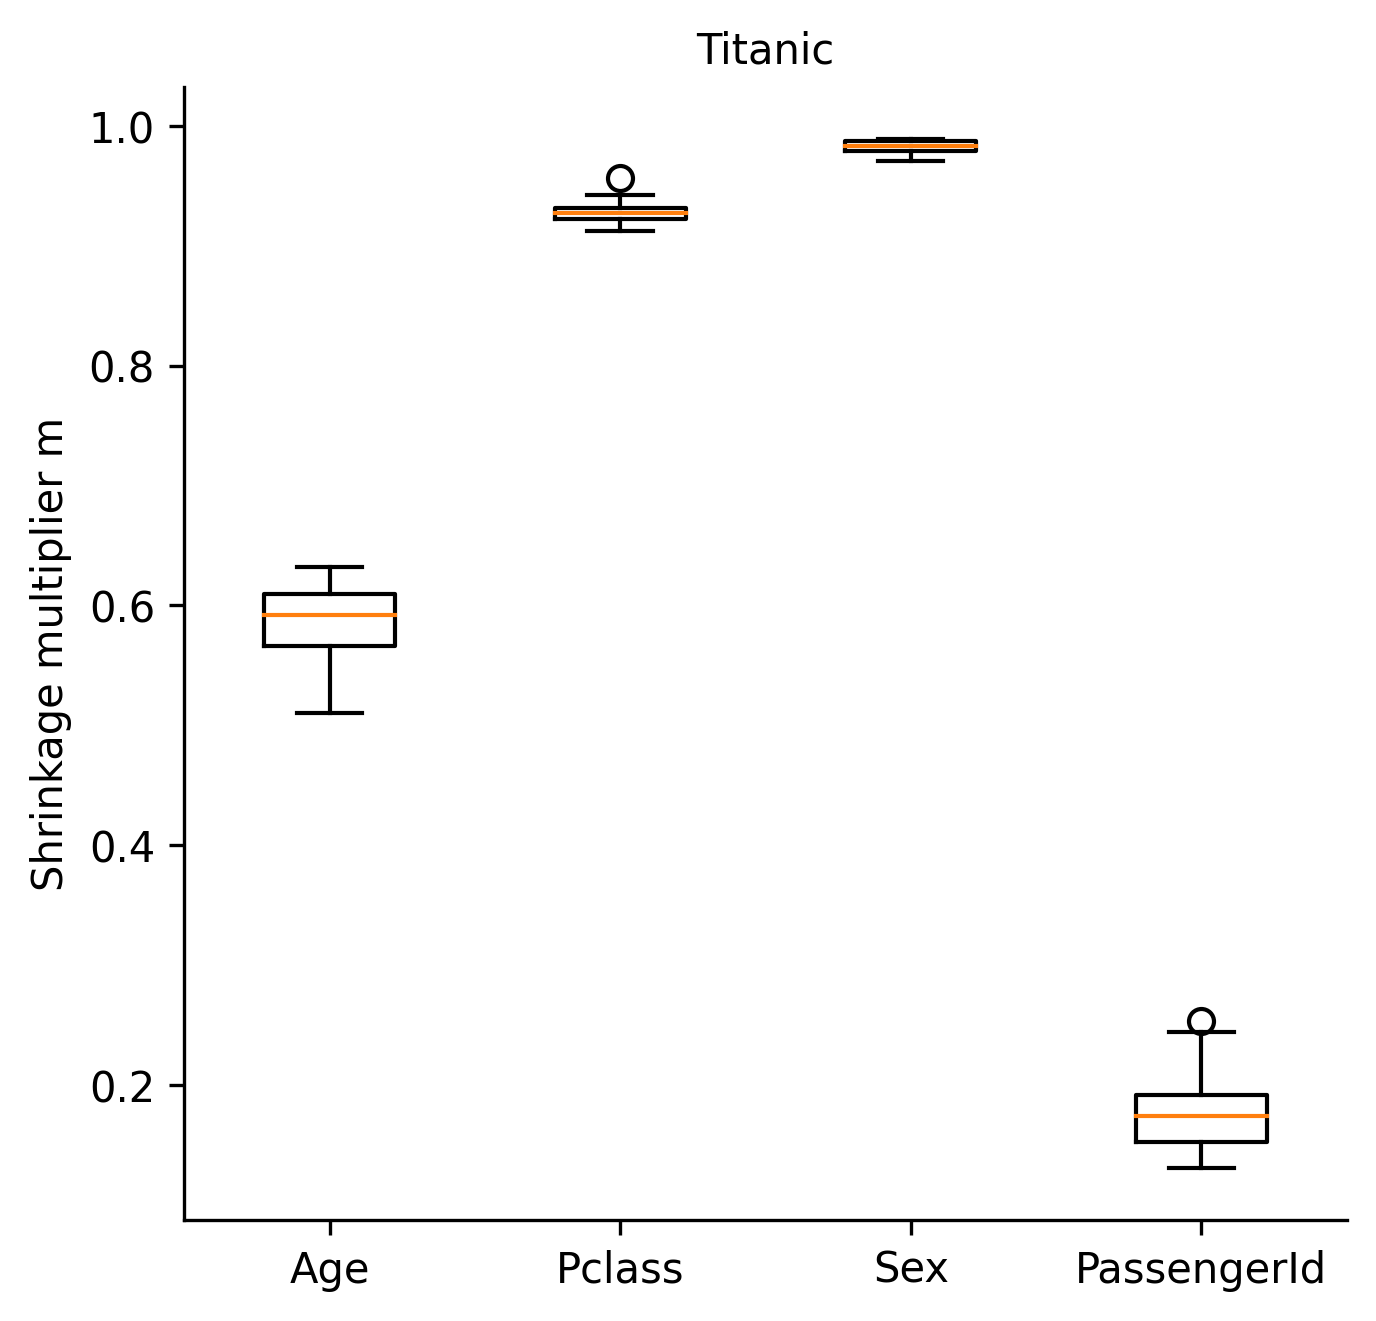

In [50]:
# Check distribution of smooth SHAP coefficients per feature accross the different models
feat_names = ['Age', 'Pclass', 'Sex', 'PassengerId']

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.boxplot(np.array(titanic_smSHAP_coefs), labels=feat_names)
ax.set_title(f"Titanic", fontsize="medium")
ax.set_ylabel("Shrinkage multiplier m")


In [53]:
dset_name = "titanic"
filename = f"AugHSsmSH_{dset_name}_coef_dist"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

### Friedman1

In [59]:
from sklearn.datasets import make_friedman1

In [61]:
# Fit models and compute smooth shap values and coefs
frie_smSHAP_coefs = np.empty((100,10))

for i in trange(100):
    X,y = make_friedman1(200,10)
    clf_frie = RandomForest(n_trees=25, n_feature=1/3, treetype="regression", oob=True , oob_SHAP=True, random_state=None)
    clf_frie.fit(X,y)
    smshap_vals_frie, _, smshap_coefs_frie = smooth_shap(clf_frie.inbag_SHAP_values, clf_frie.oob_SHAP_values)
    frie_smSHAP_coefs[i,:] = smshap_coefs_frie

 24%|██▍       | 24/100 [05:03<16:05, 12.70s/it]1 out of 200 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
Mean of empty slice
1 out of 200 samples do not have Inbag or OOB shap values. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the smooth shap score
100%|██████████| 100/100 [21:05<00:00, 12.66s/it]


In [62]:
# store simulation results as pickle file
dset_name = "friedman1"
with open(f'{data_path}/AugHSsmSH_{dset_name}_results.pickle', 'wb') as handle:
    pickle.dump([frie_smSHAP_coefs, clf_frie], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# store simulation results as pickle file
dset_name = "friedman1"
with open(f'{data_path}/AugHSsmSH_{dset_name}_results.pickle', 'rb') as input_file:
    [frie_smSHAP_coefs, clf_frie] = pickle.load(input_file)

In [7]:
#Set coefficients which are smaller than 0 to zero and higher than 1 to 1
frie_smSHAP_coefs[frie_smSHAP_coefs<0]=0
frie_smSHAP_coefs[frie_smSHAP_coefs>1]=1

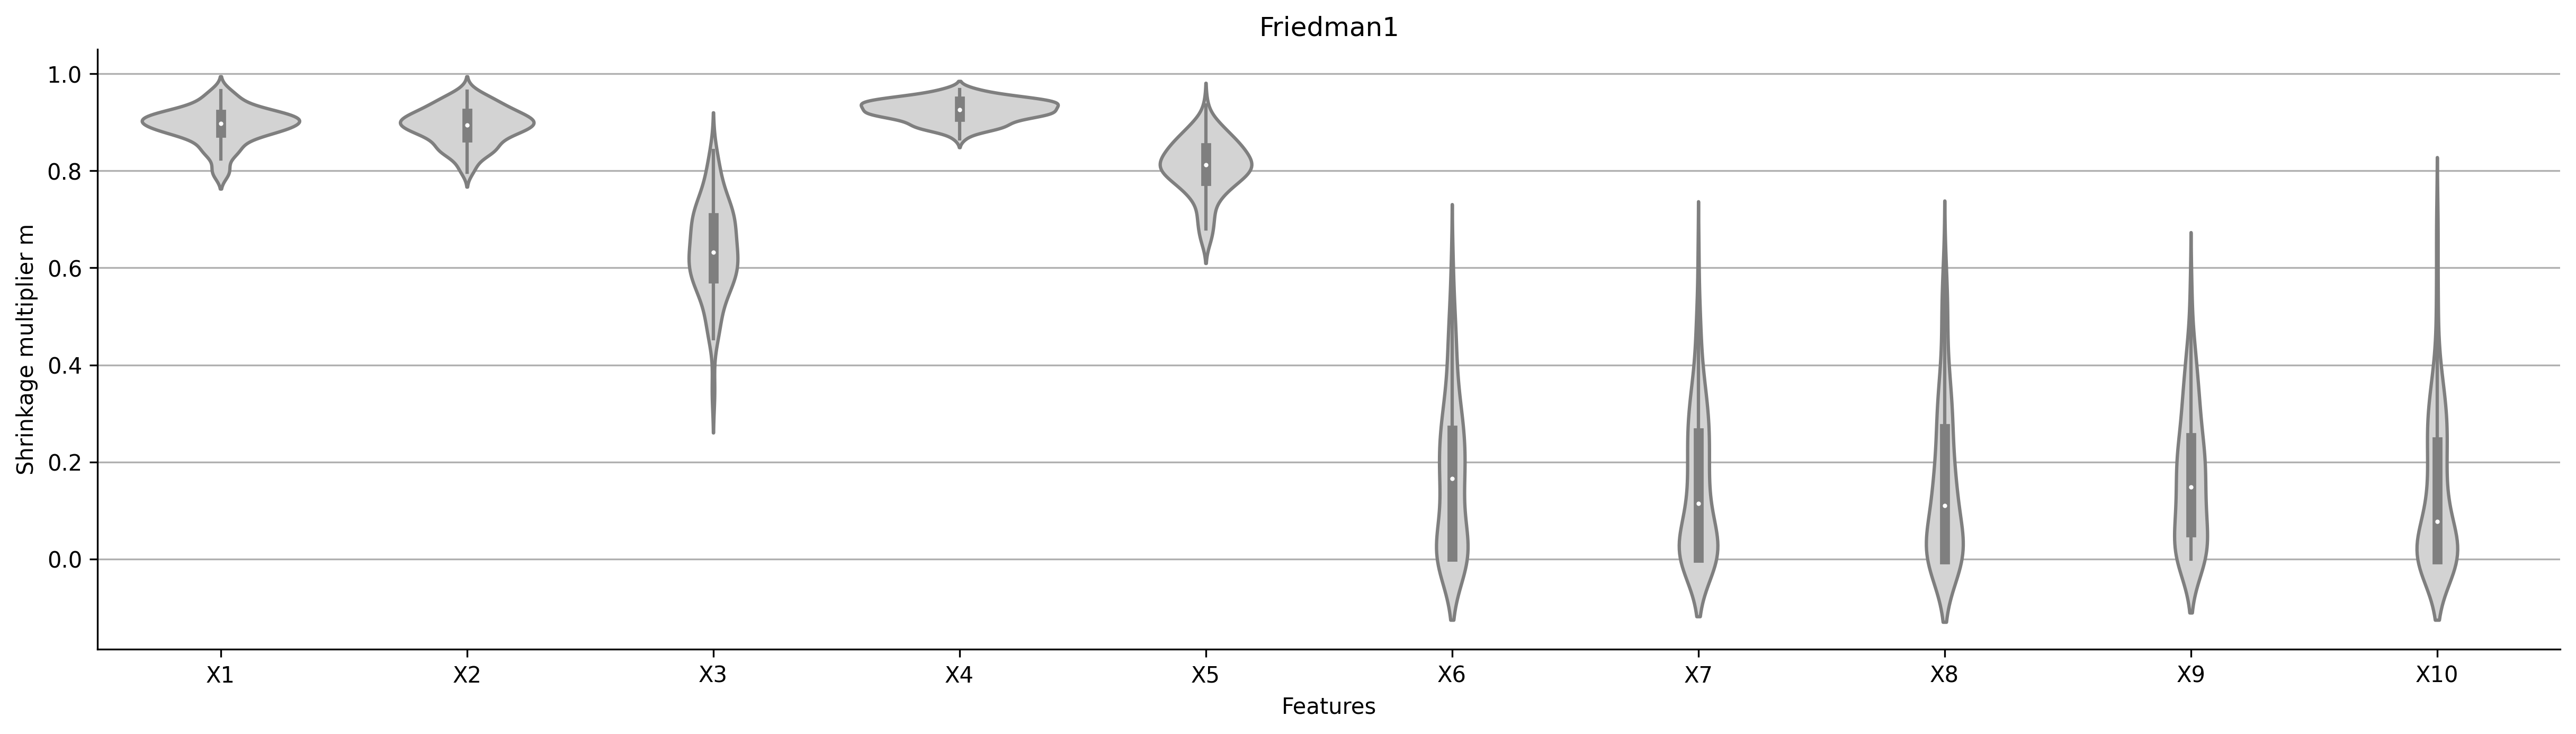

In [9]:
# Check distribution of smooth SHAP coefficients per feature accross the different models
feat_names = [f"X{i}" for i in range(1,11)]
df_frie = pd.DataFrame(frie_smSHAP_coefs, columns=feat_names).melt()
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.violinplot(x="variable", y="value", data=df_frie, ax=ax, color="lightgray")

ax.set_title(f"Friedman1")
ax.set_ylabel("Shrinkage multiplier m")
ax.set_xlabel("Features")
ax.set_axisbelow(True)
ax.grid(axis="y")

In [10]:
dset_name = "friedman1"
filename = f"AugHSsmSH_{dset_name}_coef_dist_violinplot"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

Text(0, 0.5, 'Shrinkage multiplier m')

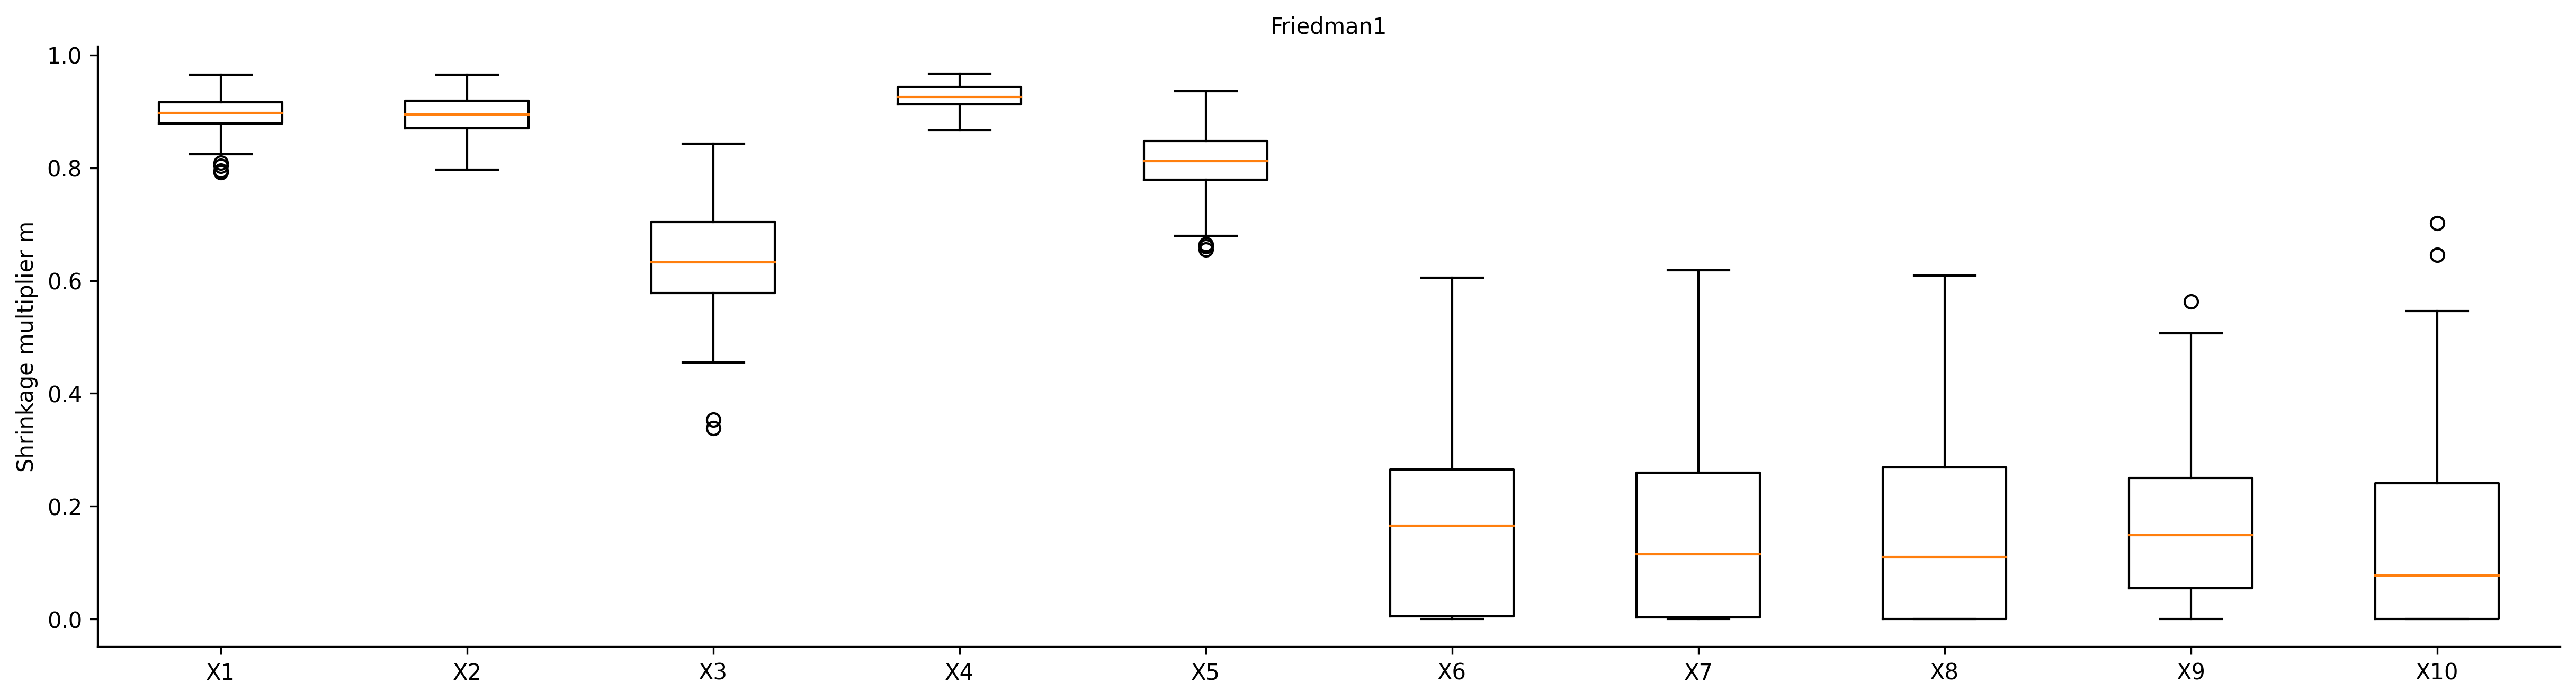

In [171]:
# Check distribution of smooth SHAP coefficients per feature accross the different models
feat_names = [f"X{i}" for i in range(1,11)]

fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.boxplot(frie_smSHAP_coefs, labels=feat_names)
ax.set_title(f"Friedman1", fontsize="medium")
ax.set_ylabel("Shrinkage multiplier m")


In [ ]:
dset_name = "friedman1"
filename = f"AugHSsmSH_{dset_name}_coef_dist"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

## AugHS MSE

### Friedman 1

#### Load data and train model

In [11]:
#load data
X, y = make_friedman1(n_samples=200, n_features=10, noise=0.0, random_state=None)

We set lambda based on results from the performance simulations

In [12]:
# Train RF model 
rf = RandomForest(n_trees=100, treetype="regression", n_feature=1/3, HShrinkage=False, HS_lambda=25, HS_nodewise_shrink_type="MSE_ratio")
rf.fit(X, y)

#### Create dataframe for plotting

In [13]:
# add m_value to node_dict
for tree in rf.trees:
    for node_id in range(tree.n_nodes):
        tree.node_id_dict[node_id]["m_value"] = tree.nodewise_HS_dict.get("m_values")[node_id]

In [14]:
# # Little helper function to find parend node id
# def find_parent_node_id(tree, child_id):
#     for path in tree.decision_paths:
#         if child_id ==0:
#             return -1 #set -1 for root node
#         elif child_id in path:
#             return path[path.index(child_id)-1]


In [15]:
# Create dataframe for each tree and concat for plotting
dfs=[]

for i, tree in enumerate(rf.trees):
    
    # create dataframe out of tree node_id_dict
    df = pd.DataFrame.from_dict(tree.node_id_dict).T[['id', 'depth', "feature", 'samples', 'm_value']]
    df["tree_id"]=i
    df.rename(columns={"id":"node_id", "depth":"node_depth", "feature":"child_feature"}, inplace=True)
    df = df.astype({'node_id': int, "node_depth": int, "samples": int, "m_value": float})
    
    # # add columns regarding parent_node (not necessary)
    # df["parent_node_id"] = df.node_id.apply(lambda x: find_parent_node_id(tree, x))
    # df["parent_node_feature"] = df.parent_node_id.apply(lambda x: df.loc[x,"child_feature"] if x!=-1 else df.loc[0, "child_feature"])
    
    dfs.append(df)
    
df_plot = pd.concat(dfs, ignore_index=True)

In [16]:
# store simulation results as pickle file
dset_name = "friedman1"
with open(f'{data_path}/AugHSmse_{dset_name}_results.pickle', 'wb') as handle:
    pickle.dump([df_plot, rf], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# store simulation results as pickle file
dset_name = "friedman1"
with open(f'{data_path}/AugHSmse_{dset_name}_results.pickle', 'rb') as input_file:
    [df_plot, rf] = pickle.load(input_file)

In [6]:
df_plot.loc[df_plot["m_value"]<0, "m_value"]=0
df_plot.loc[df_plot["m_value"]>1, "m_value"]=1

#### Stripplots

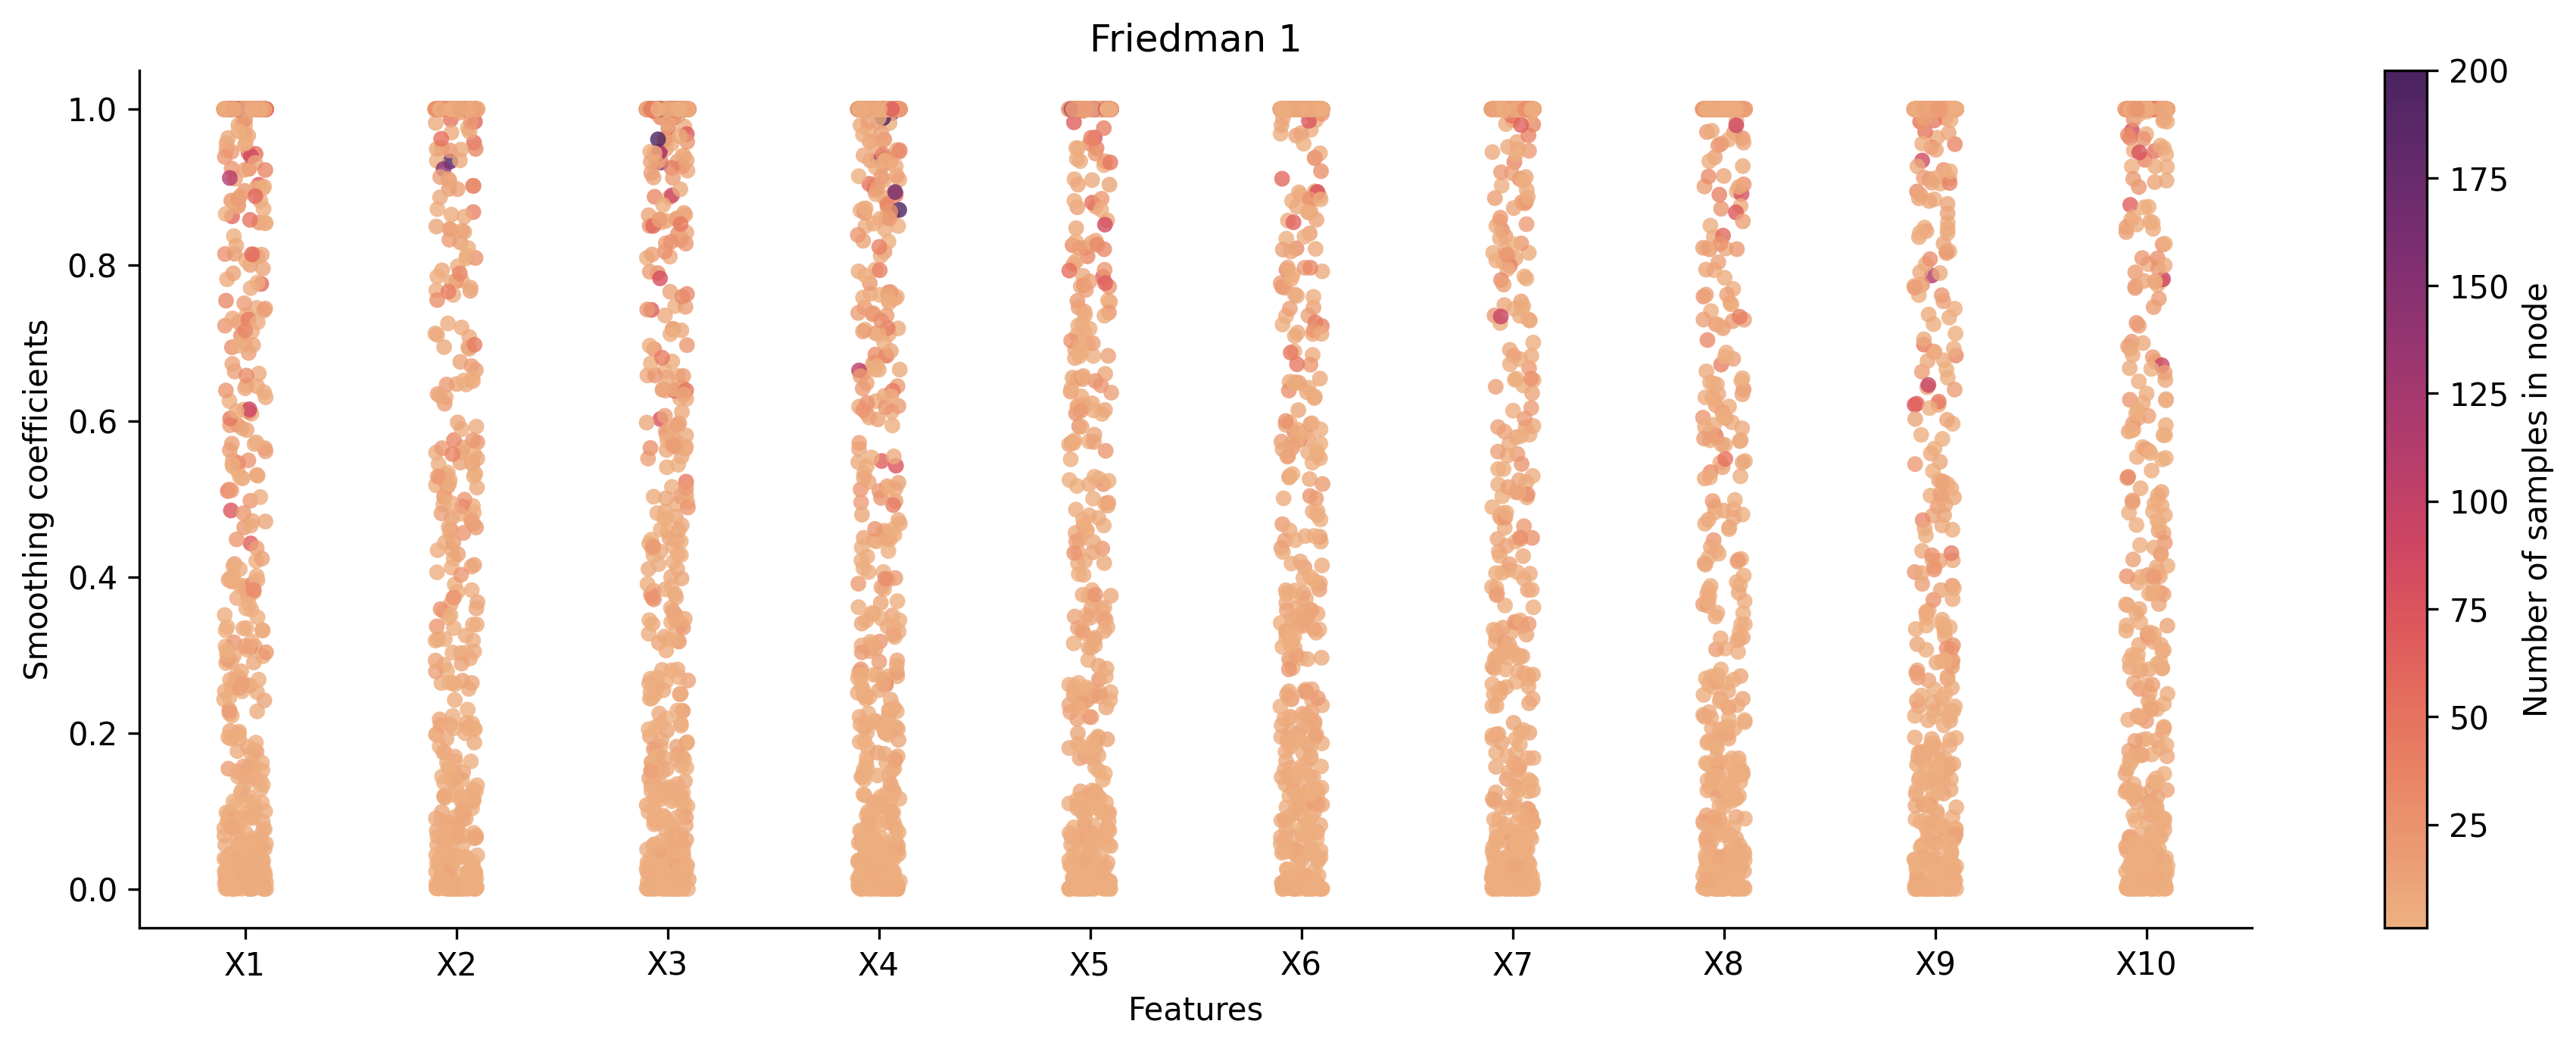

In [7]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=1, vmax=df_plot.samples.max()) 
palette = {h: cmap(norm(h)) for h in df_plot['samples']}

p = sns.stripplot(data=df_plot, x='child_feature', y='m_value', hue='samples', palette=palette, alpha=0.8, ax=axs)
p.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,11)])
axs.set_title(f"Friedman 1")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Number of samples in node")  # optionally add a colorbar
plt.show()

In [8]:
dset_name = "friedman1"
filename = f"AugHSmse_{dset_name}_coef_dist_stripplot_smplnode"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

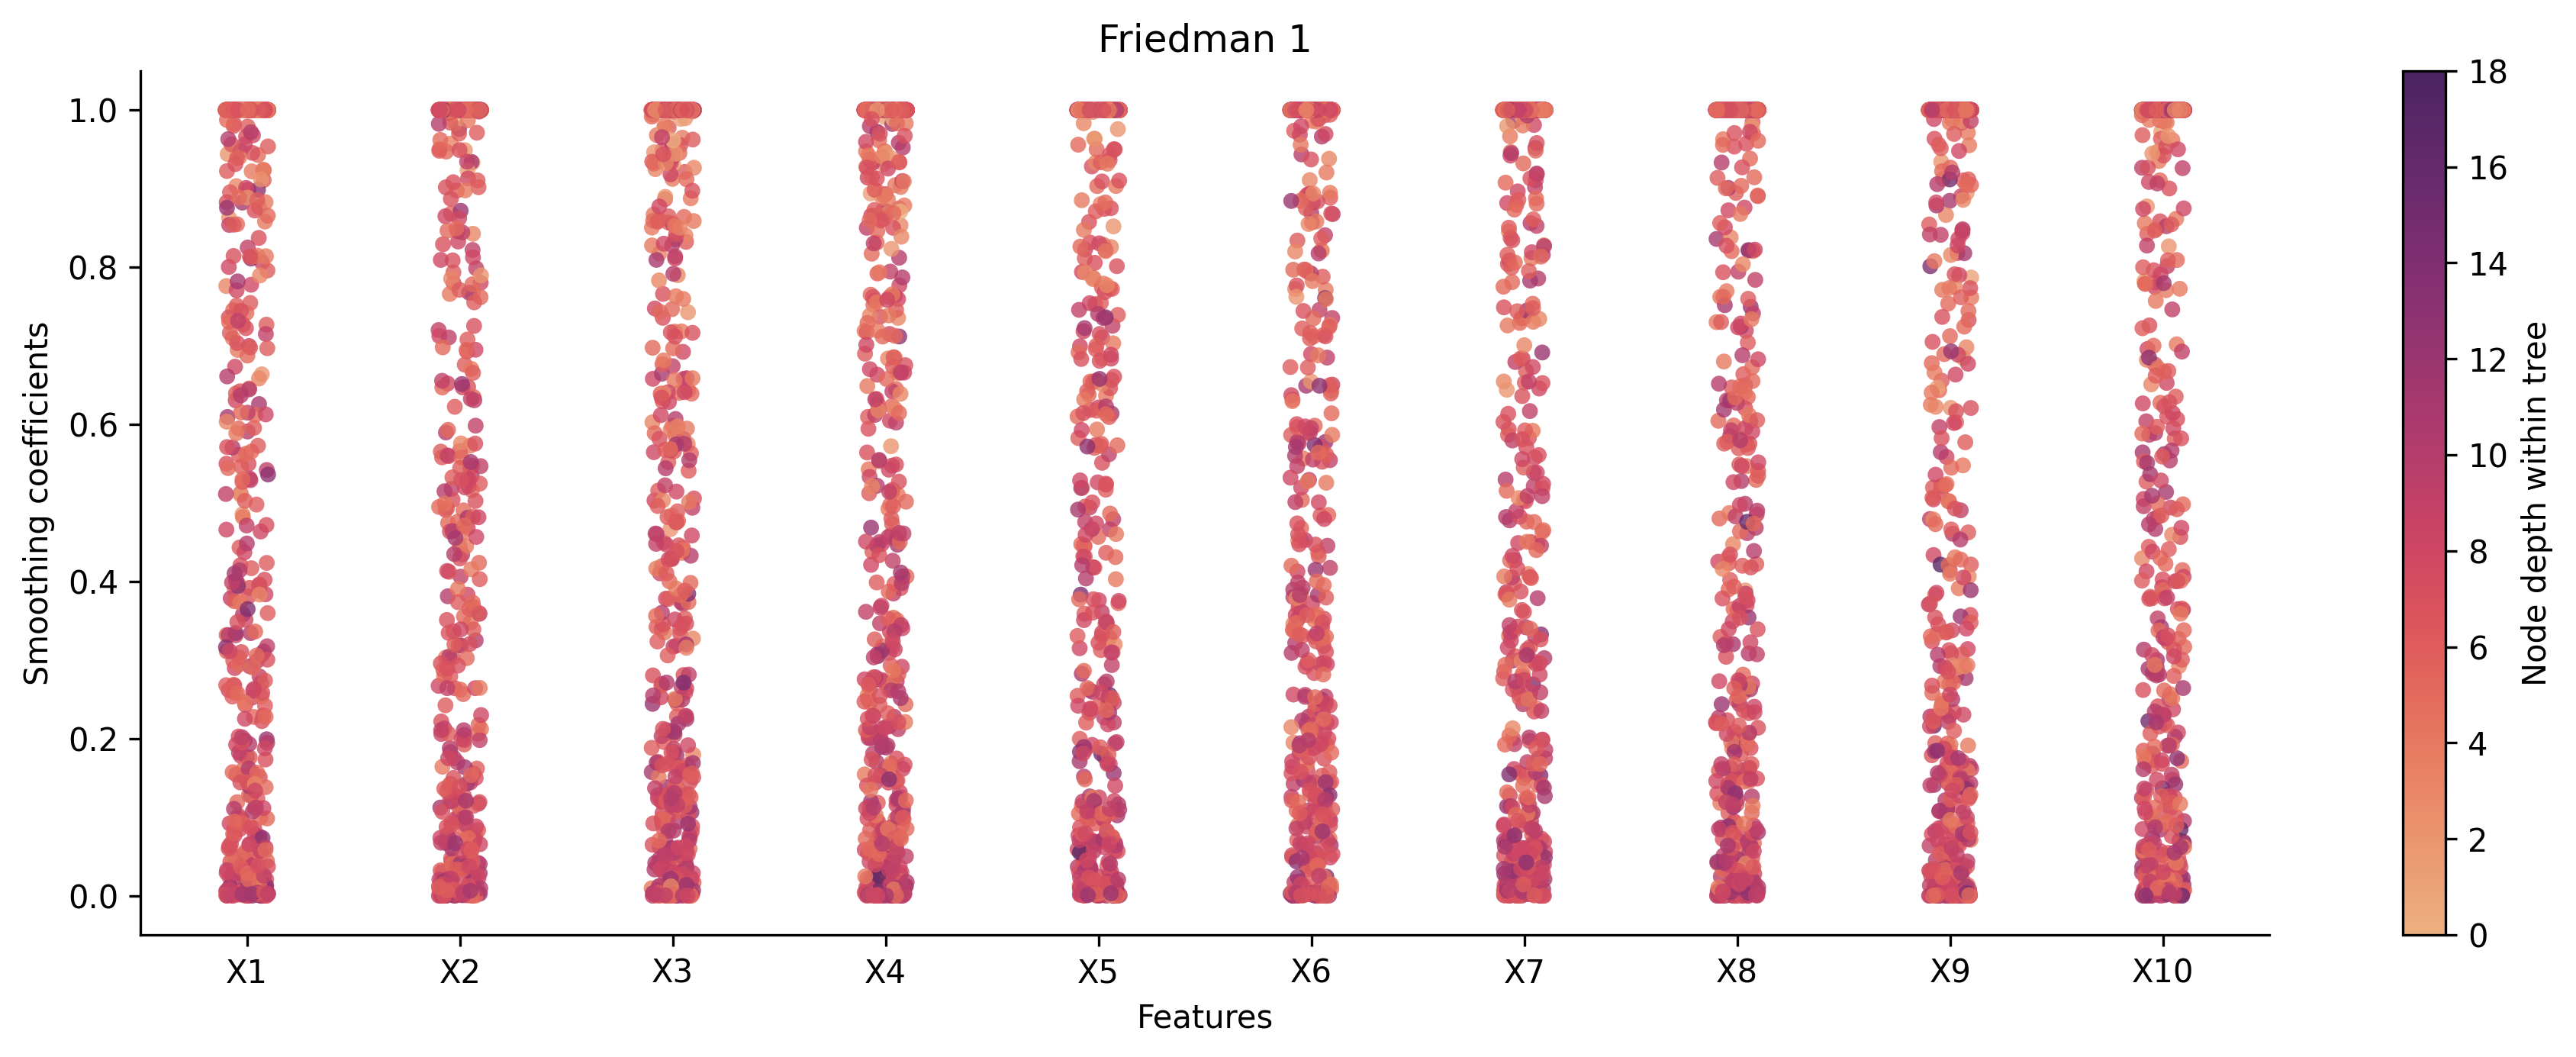

In [9]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=df_plot.node_depth.max()) 
palette = {h: cmap(norm(h)) for h in df_plot['node_depth']}

p = sns.stripplot(data=df_plot, x='child_feature', y='m_value', hue='node_depth', palette=palette, alpha=0.8, ax=axs)
p.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,11)])
axs.set_title(f"Friedman 1")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Node depth within tree")  # optionally add a colorbar
plt.show()

In [10]:
dset_name = "friedman1"
filename = f"AugHSmse_{dset_name}_coef_dist_stripplot_nodedepth"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

#### Histplot

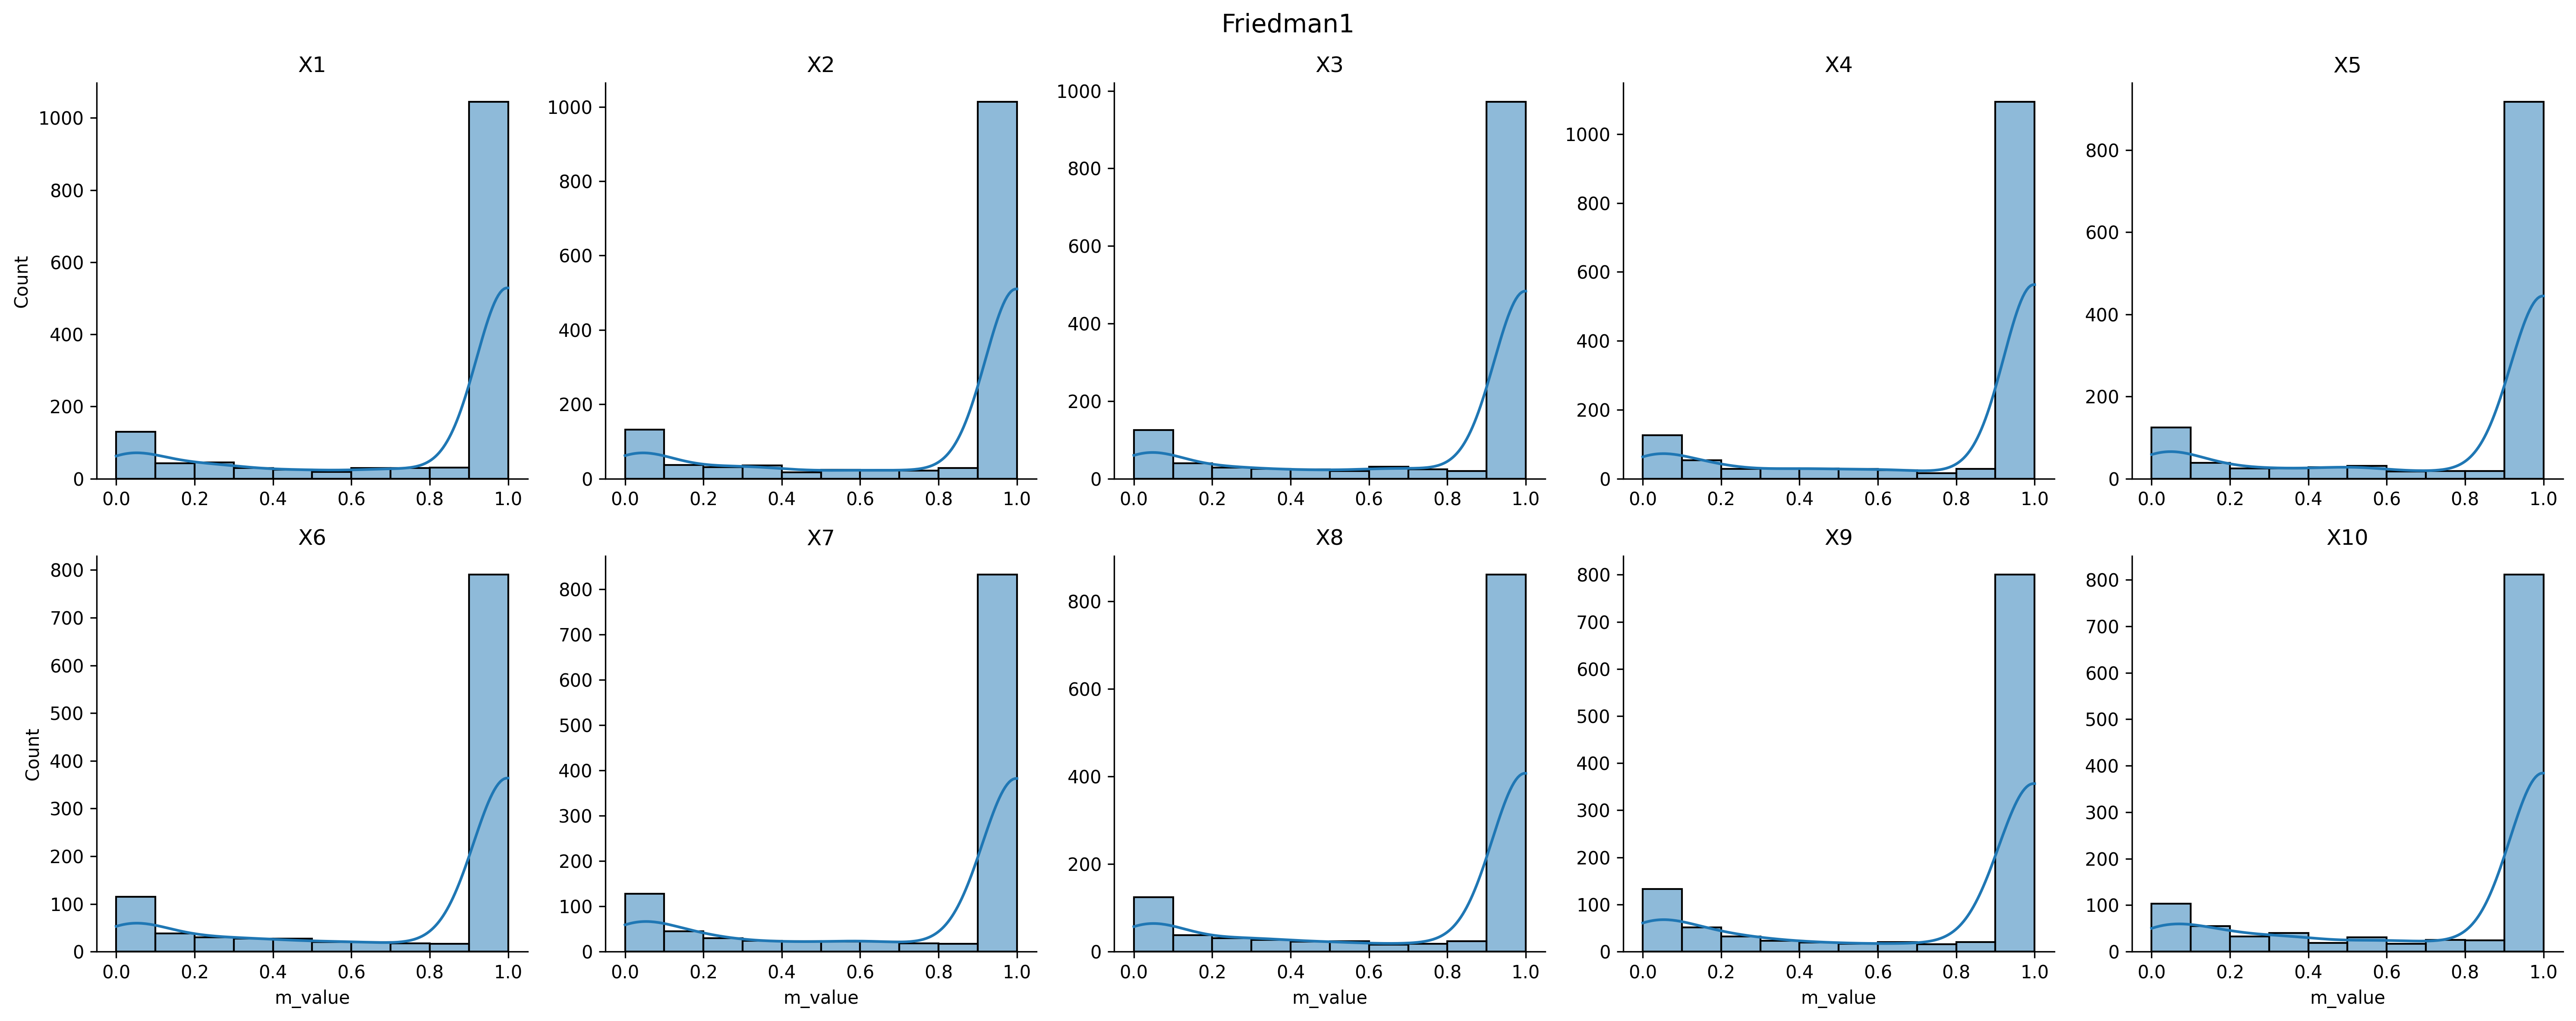

In [15]:

fig, axs2d = plt.subplots(2,5, figsize=(20,8), squeeze=False)
axs = axs2d.flatten()

fig.suptitle('Friedman1', fontsize=14)

for i, ax in enumerate(axs):
    df = df_plot.loc[(df_plot["child_feature"]!=None)&(df_plot["child_feature"]==i)]
    sns.histplot(data=df, x="m_value", ax=ax, palette="crest", binwidth=0.1, kde=True)#, hue="node_depth", warn_singular=False)
    ax.set_title(f"X{i+1}")
    if i not in [0,5]:
        ax.set(ylabel=None)
    if i <5:
        ax.set(xlabel=None)
    
#plt.setp(axs, ylim=[0,1]) #set global ylim for all suplots
plt.tight_layout()

In [16]:
dset_name = "friedman1"
filename = f"AugHSmse_{dset_name}_coef_dist_histplot"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

#### Violinplot

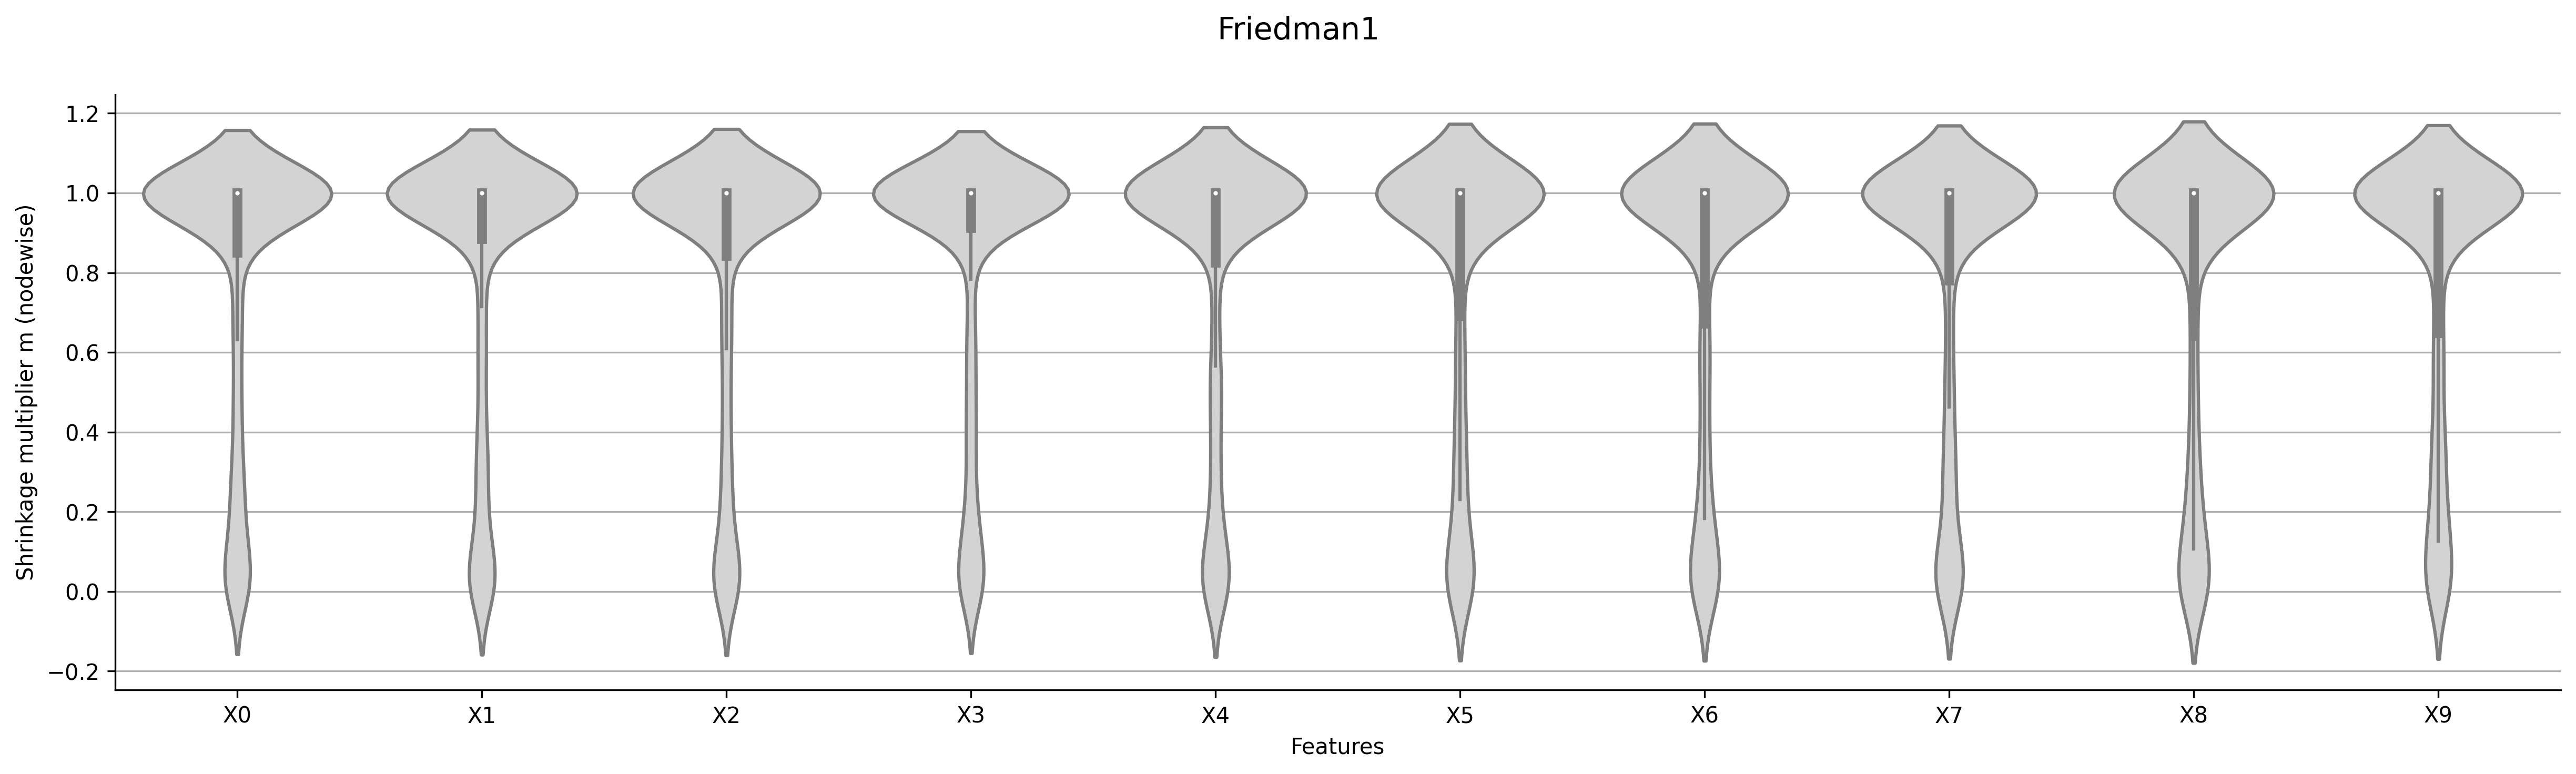

In [13]:
fig, ax = plt.subplots(1,1, figsize=(20,5))

fig.suptitle('Friedman1', fontsize=14)
df = df_plot.loc[(df_plot["child_feature"]!=None)]

sns.violinplot(data=df, x="child_feature", y="m_value", color="lightgray", ax=ax, order=range(10))
ax.set_xticklabels([f"X{i}" for i in range(10)])
ax.set_xlabel("Features")
ax.set_ylabel("Shrinkage multiplier m (nodewise)")
ax.set_axisbelow(True)
ax.grid(axis="y")

In [14]:
dset_name = "friedman1"
filename = f"AugHSmse_{dset_name}_coef_dist_violinplot"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

#### Kdeplot per node depth

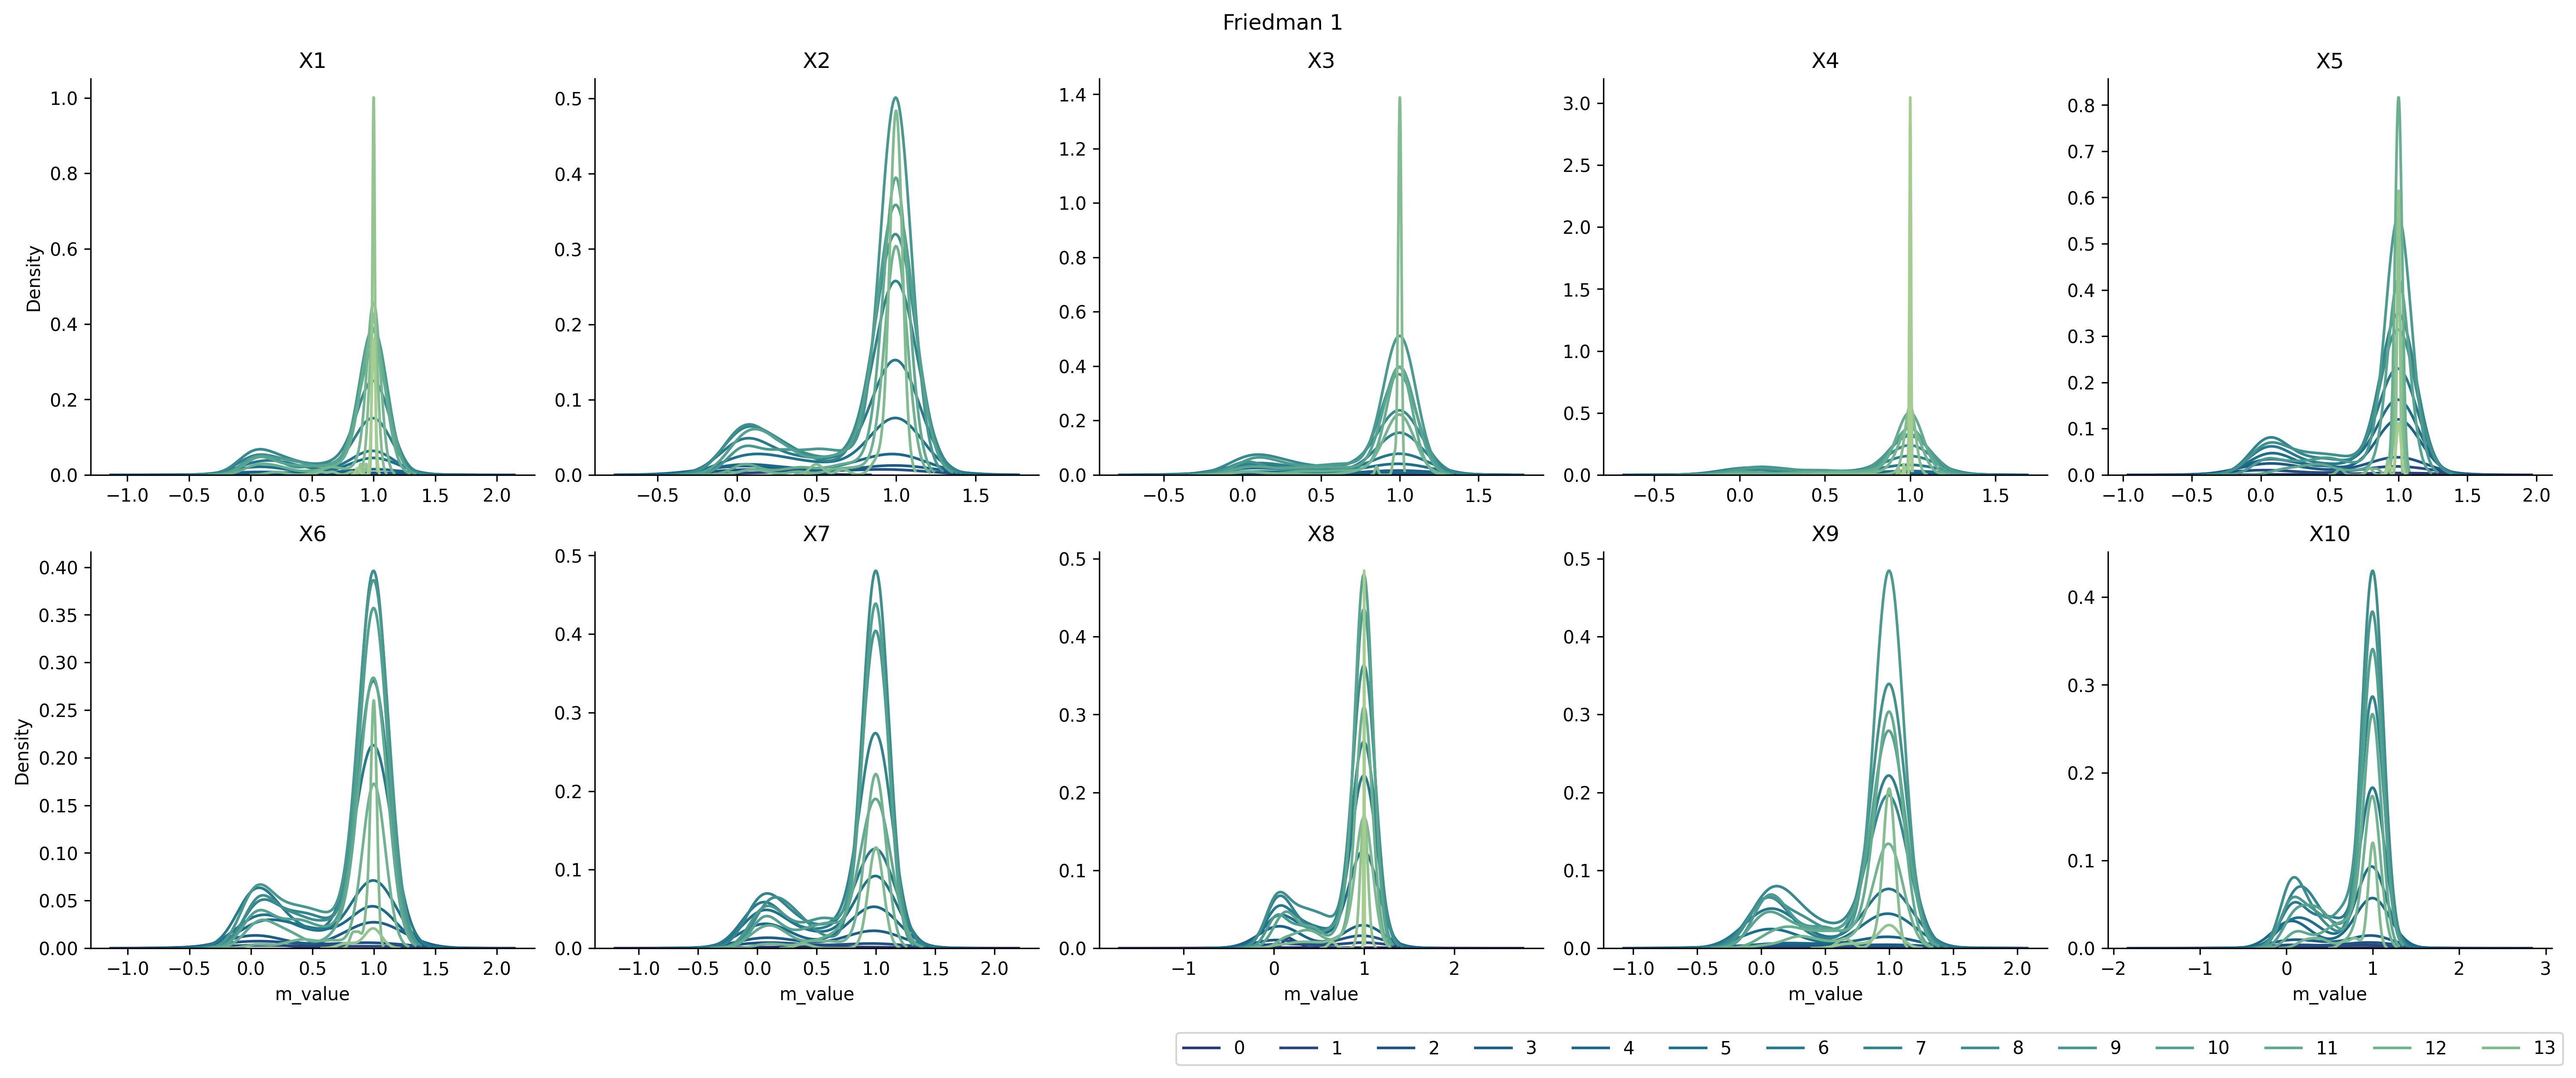

In [18]:
fig, axs2d = plt.subplots(2,5, figsize=(20,8), squeeze=False)
axs = axs2d.flatten()
fig.suptitle(f"Friedman 1")

for i, ax in enumerate(axs):
    df = df_plot.loc[(df_plot["child_feature"]!=None)&(df_plot["child_feature"]==i)]
    sns.kdeplot(data=df, x="m_value", hue="node_depth", ax=ax, palette="crest", warn_singular=False)
    ax.set_title(f"X{i+1}")
    ax.get_legend().remove()
    if i not in [0,5]:
        ax.set(ylabel=None)
    if i <5:
        ax.set(xlabel=None)
    
plt.tight_layout()
#plt.setp(axs, ylim=[0,1]) #set global ylim for all suplots
plt.legend(range(16), bbox_to_anchor=(1, 0), loc="upper right", bbox_transform=fig.transFigure, ncol=16);


In [ ]:
dset_name = "friedman1"
filename = f"AugHSmse_{dset_name}_coef_dist_kdeplot_nodedepth"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

### Titanic

#### Load data and train model

In [31]:
#Load and clean data
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)
X_titanic = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y_titanic = data["Survived"].astype("float")

In [32]:
# Train RF model 
grid = {"HS_lambda":[0.1,1,5,10,25,50,100]}
rf_titanic = RandomForest(n_trees=100, treetype="classification", HShrinkage=False, HS_nodewise_shrink_type="MSE_ratio")
titanic_grid_cv = GridSearchCV_scratch(rf_titanic, grid, X_titanic, y_titanic, cv=3, scoring_func=roc_auc_score)
titanic_grid_cv.get("best_param_comb")

(50,)

Lambda=50 is the best hyperparameter setting according to 3 fold GridSearch

In [215]:
with open(f'{data_path}/titanic_MSEratio_model.pickle', 'wb') as handle:
    pickle.dump(rf_titanic, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Create df for plotting

In [33]:
# add m_value to node_dict
for tree in rf_titanic.trees:
    for node_id in range(tree.n_nodes):
        tree.node_id_dict[node_id]["m_value"] = tree.nodewise_HS_dict.get("m_values")[node_id]

In [34]:
# Create dataframe for each tree and concat for plotting
dfs_tit=[]

for i, tree in enumerate(rf_titanic.trees):
    
    # create dataframe out of tree node_id_dict
    df = pd.DataFrame.from_dict(tree.node_id_dict).T[['id', 'depth', "feature", 'samples', 'm_value']]
    df["tree_id"]=i
    df.rename(columns={"id":"node_id", "depth":"node_depth", "feature":"child_feature"}, inplace=True)
    df = df.astype({'node_id': int, "node_depth": int, "samples": int, "m_value": float})
    
    # # add columns regarding parent_node (not necessarry)
    # df["parent_node_id"] = df.node_id.apply(lambda x: find_parent_node_id(tree, x))
    # df["parent_node_feature"] = df.parent_node_id.apply(lambda x: df.loc[x,"child_feature"] if x!=-1 else df.loc[0, "child_feature"])
    # df["parent_node_samples"] = df.parent_node_id.apply(lambda x: df.loc[x,"samples"] if x!=-1 else df.loc[0, "samples"])
    
    dfs_tit.append(df)
    
df_plot_tit = pd.concat(dfs_tit, ignore_index=True)

#### Stripplot
Create plot by sample size

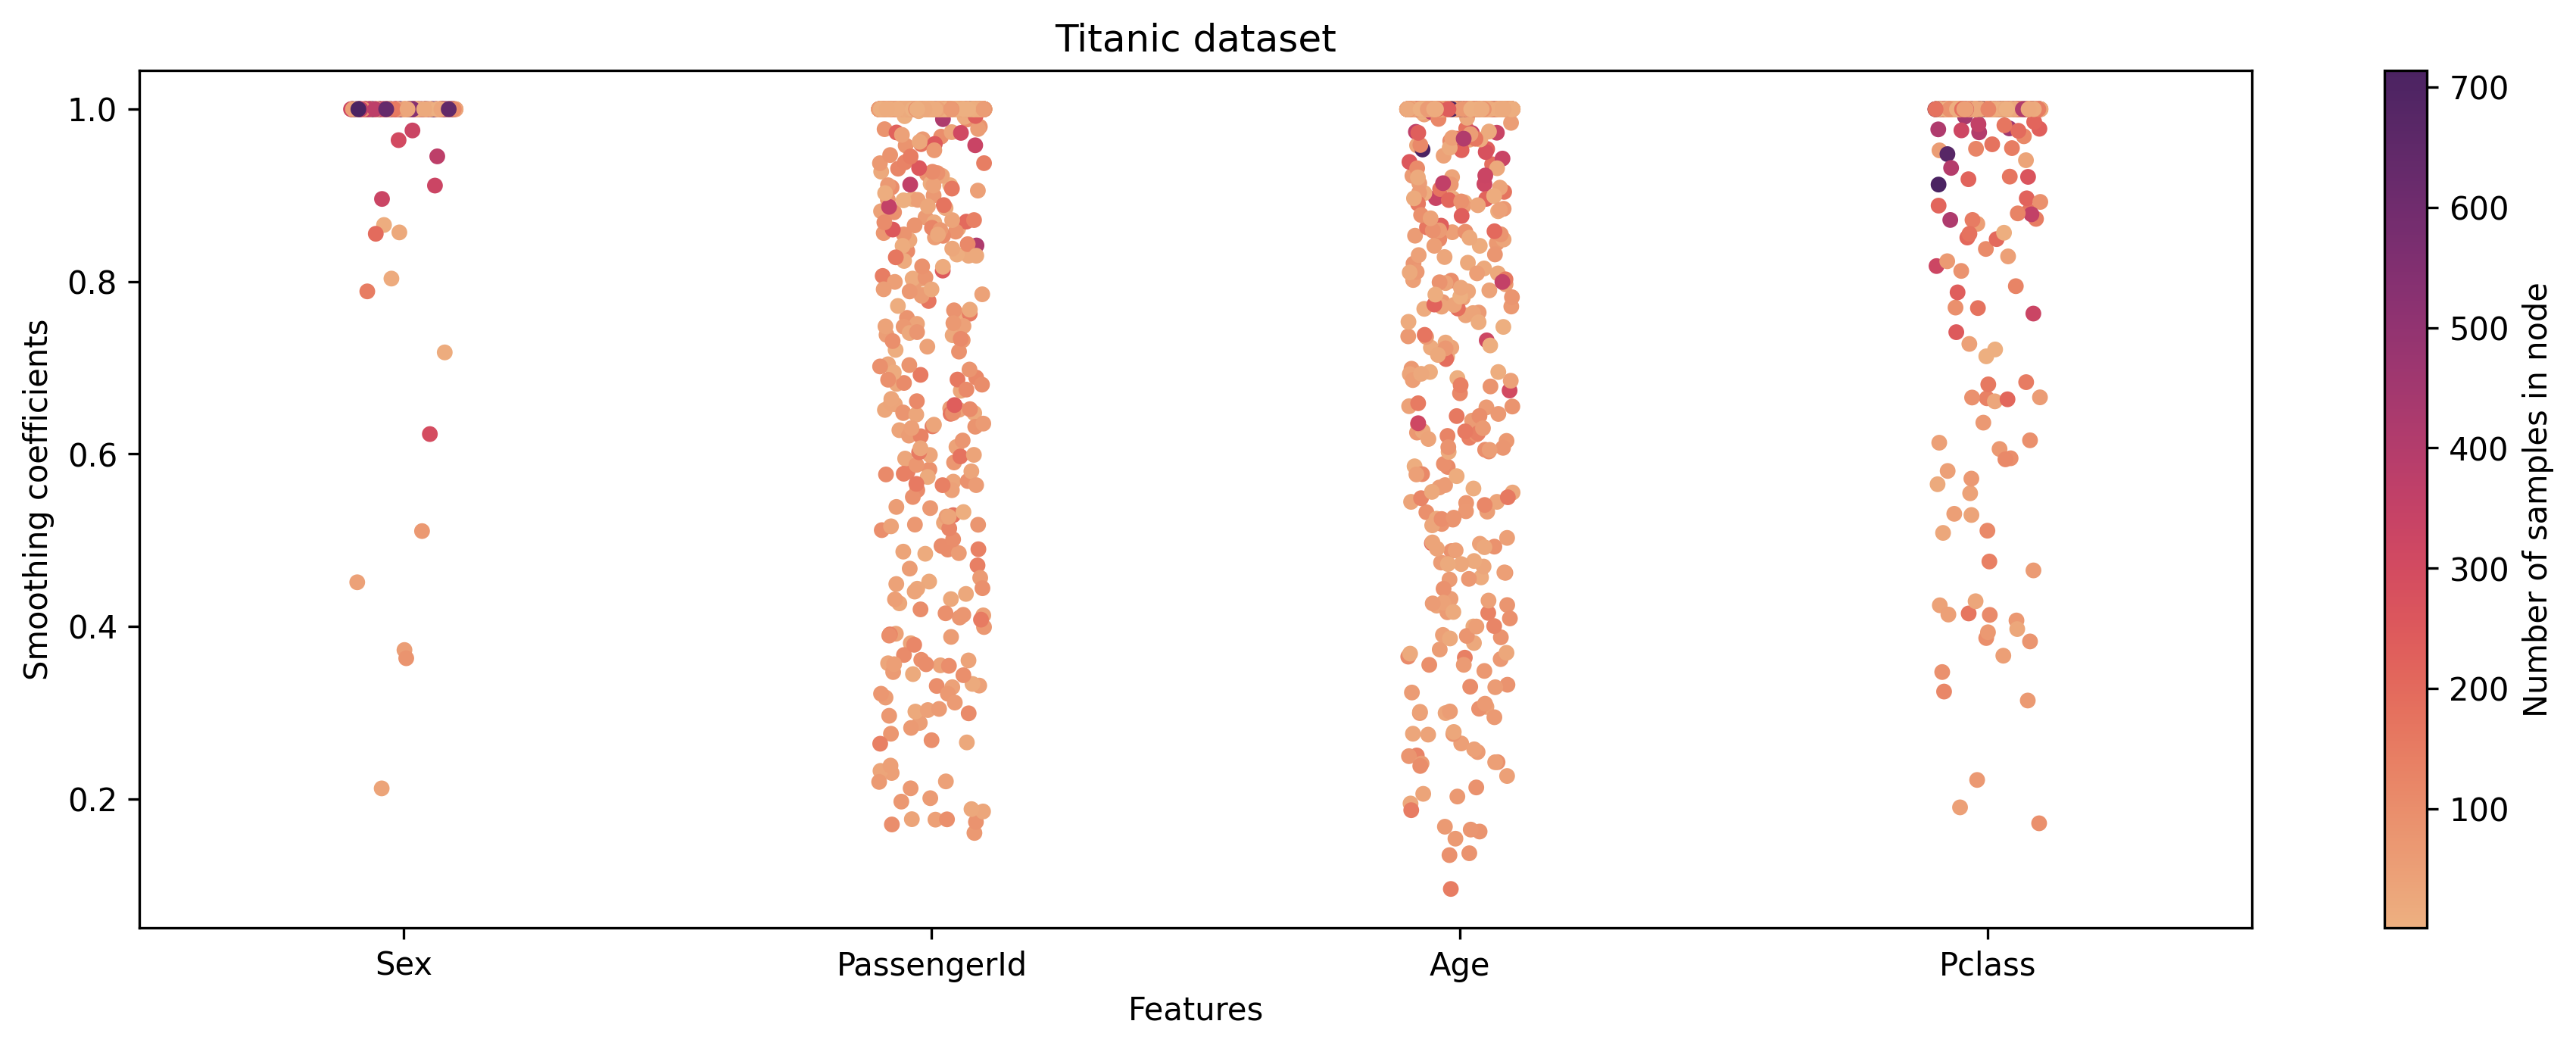

In [124]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=1, vmax=df_plot_tit.samples.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_tit['samples']}

t = sns.stripplot(data=df_plot_tit, x='child_feature', y='m_value', hue='samples', palette=palette, alpha=1, ax=axs)
t.legend_.remove()  # remove the categorical legend

#axs.set_xticklabels([f"X{i}" for i in range(1,11)])
axs.set_title(f"Titanic dataset")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Number of samples in node")  # optionally add a colorbar
plt.show()

In [89]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "titanic_MSEratio_coef_dist_plot_sample_size"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

Create plot based on node depth in tree

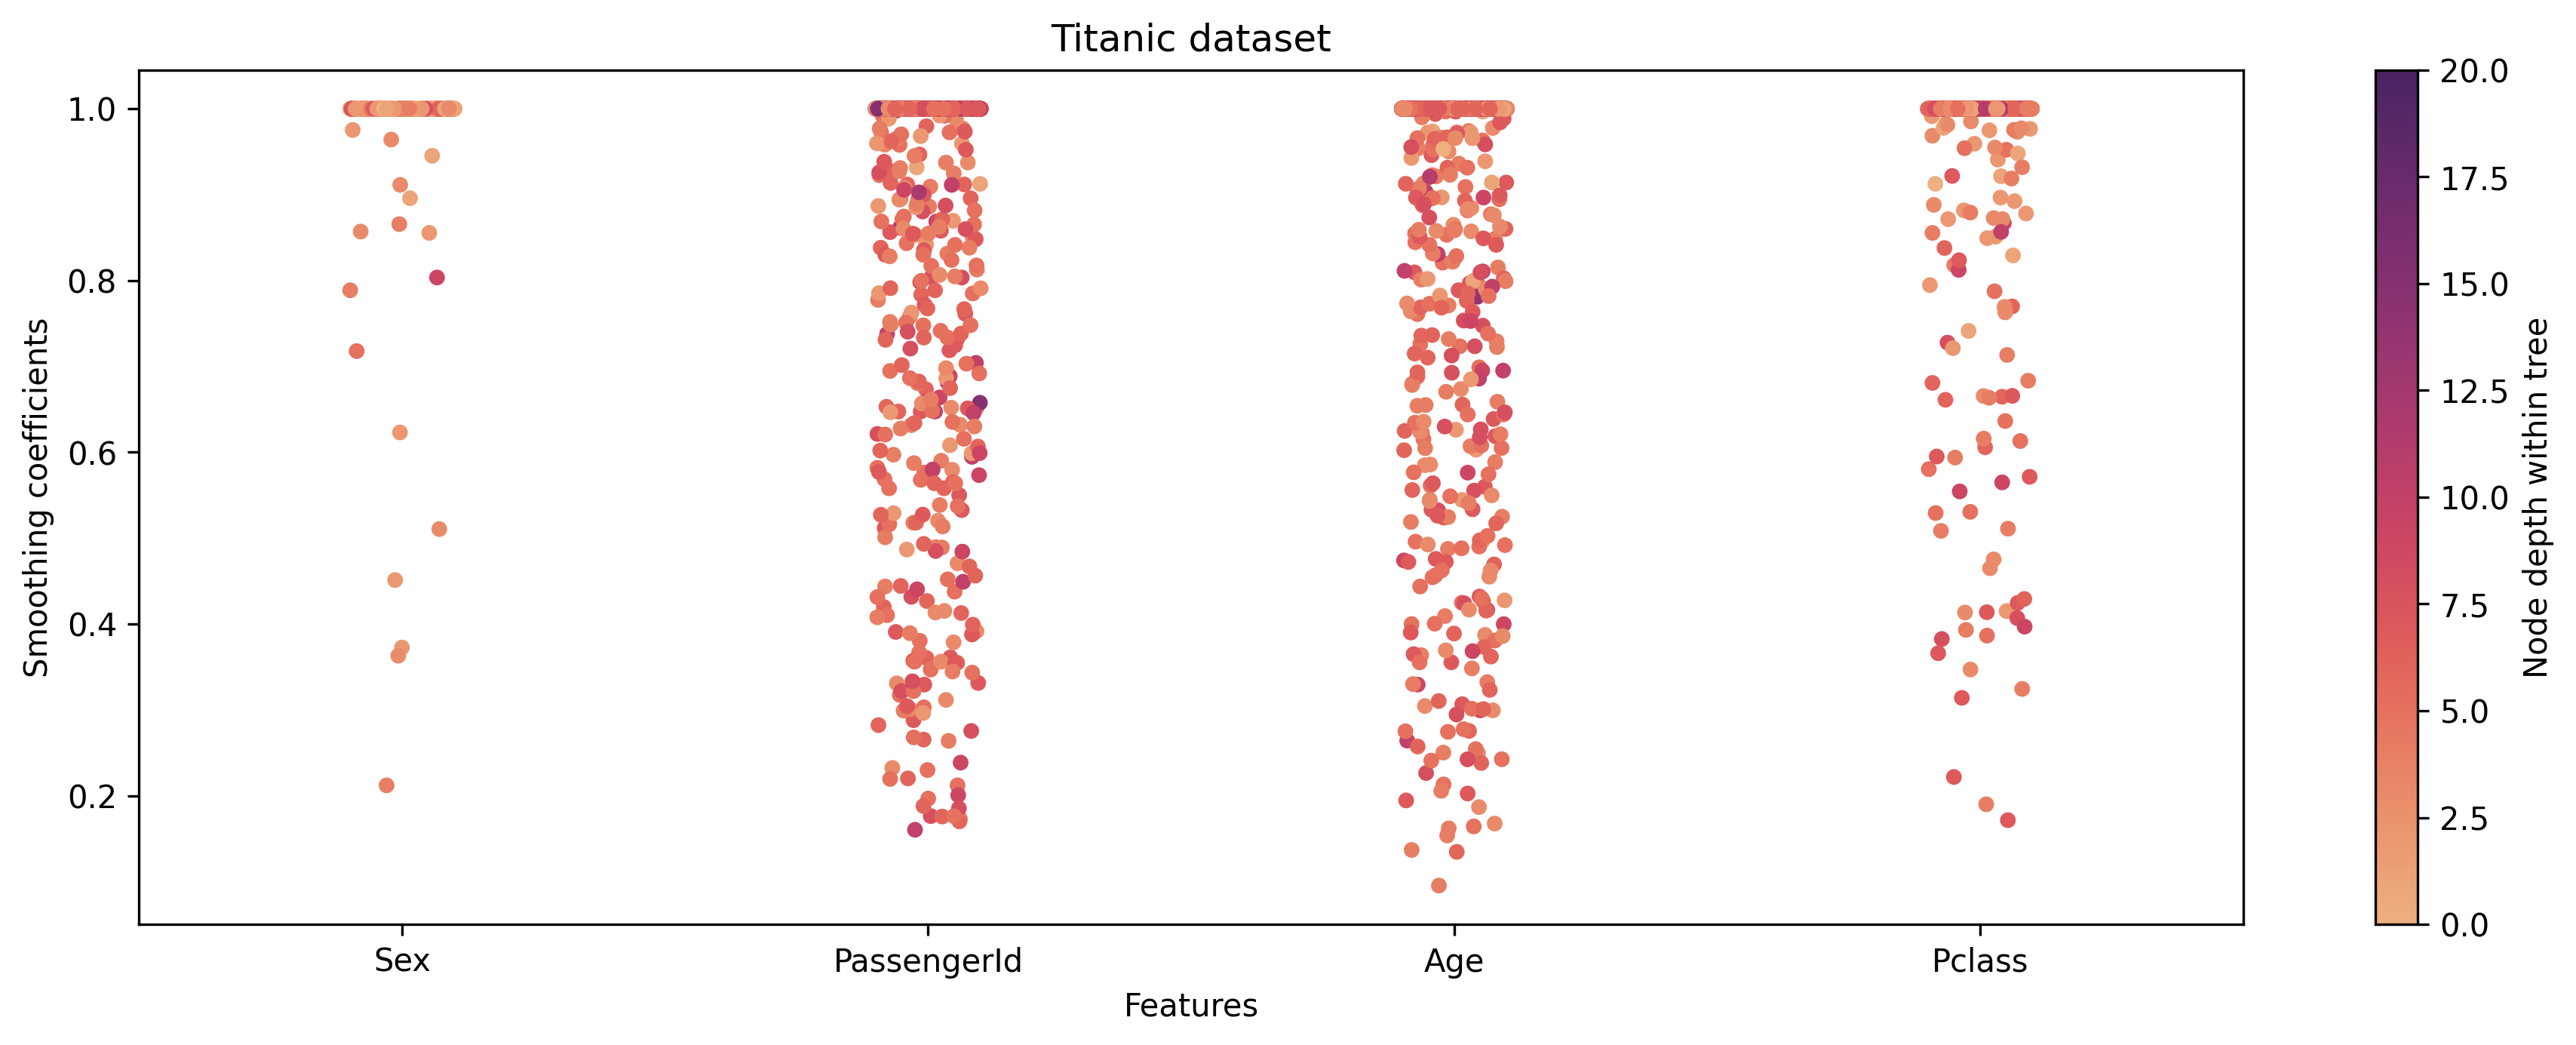

In [123]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=df_plot_tit.node_depth.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_tit['node_depth']}

t = sns.stripplot(data=df_plot_tit, x='child_feature', y='m_value', hue='node_depth', palette=palette, alpha=1, ax=axs)
t.legend_.remove()  # remove the categorical legend

#axs.set_xticklabels([f"X{i}" for i in range(1,11)])
axs.set_title(f"Titanic dataset")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Node depth within tree")  # optionally add a colorbar
plt.show()

In [98]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "titanic_MSEratio_coef_dist_plot_node_depth"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

### Strobl

#### Create function to simulate Strobl data and train models

In [5]:
def simulate_data_strobl(n=120, # number of rows in data
                         M=10, # number of simulations
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n,M))
    x2 = random_state.randint(1, 3, size=(n,M))
    x3 = random_state.randint(1, 5, size=(n,M))
    x4 = random_state.randint(1, 11, size=(n,M))
    x5 = random_state.randint(1, 21, size=(n,M))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* relevance))

    return X, y

In [6]:
#Null simulation
X_null, y_null = simulate_data_strobl(n=120, M=1, relevance=0)
#Power simulation
X_power, y_power = simulate_data_strobl(n=120, M=1, relevance=0.15)

Again we set lambda based on previous gridsearch results

In [7]:
# Fit models
i=0
null_rfHSmse = RandomForest(n_trees=100, HS_lambda=25, treetype="classification", oob=True, HS_nodewise_shrink_type="MSE_ratio")
null_rfHSmse.fit(X_null[i,:,:], y_null[:,i])

power_rfHSmse = RandomForest(n_trees=100, HS_lambda=1, treetype="classification", oob=True, HS_nodewise_shrink_type="MSE_ratio")
power_rfHSmse.fit(X_null[i,:,:], y_null[:,i])

#### Create dataframes for plotting

In [8]:
# add m_value to node_dict NULL
for tree in null_rfHSmse.trees:
    for node_id in range(tree.n_nodes):
        tree.node_id_dict[node_id]["m_value"] = tree.nodewise_HS_dict.get("m_values")[node_id]
        
# add m_value to node_dict POWER
for tree in power_rfHSmse.trees:
    for node_id in range(tree.n_nodes):
        tree.node_id_dict[node_id]["m_value"] = tree.nodewise_HS_dict.get("m_values")[node_id]

In [9]:
# Create dataframe for each tree and concat for plotting
dfs_null=[]

for i, tree in enumerate(null_rfHSmse.trees):
    
    # create dataframe out of tree node_id_dict
    df = pd.DataFrame.from_dict(tree.node_id_dict).T[['id', 'depth', "feature", 'samples', 'm_value']]
    df["tree_id"]=i
    df.rename(columns={"id":"node_id", "depth":"node_depth", "feature":"child_feature"}, inplace=True)
    df = df.astype({'node_id': int, "node_depth": int, "samples": int, "m_value": float})
    
    # # add columns regarding parent_node (not necessarry)
    # df["parent_node_id"] = df.node_id.apply(lambda x: find_parent_node_id(tree, x))
    # df["parent_node_feature"] = df.parent_node_id.apply(lambda x: df.loc[x,"child_feature"] if x!=-1 else df.loc[0, "child_feature"])
    # df["parent_node_samples"] = df.parent_node_id.apply(lambda x: df.loc[x,"samples"] if x!=-1 else df.loc[0, "samples"])
    
    dfs_null.append(df)
    
df_plot_null = pd.concat(dfs_null, ignore_index=True)

In [10]:
# Create dataframe for each tree and concat for plotting
dfs_power=[]

for i, tree in enumerate(power_rfHSmse.trees):
    
    # create dataframe out of tree node_id_dict
    df = pd.DataFrame.from_dict(tree.node_id_dict).T[['id', 'depth', "feature", 'samples', 'm_value']]
    df["tree_id"]=i
    df.rename(columns={"id":"node_id", "depth":"node_depth", "feature":"child_feature"}, inplace=True)
    df = df.astype({'node_id': int, "node_depth": int, "samples": int, "m_value": float})
    
    # # add columns regarding parent_node (not necessarry)
    # df["parent_node_id"] = df.node_id.apply(lambda x: find_parent_node_id(tree, x))
    # df["parent_node_feature"] = df.parent_node_id.apply(lambda x: df.loc[x,"child_feature"] if x!=-1 else df.loc[0, "child_feature"])
    # df["parent_node_samples"] = df.parent_node_id.apply(lambda x: df.loc[x,"samples"] if x!=-1 else df.loc[0, "samples"])
    
    dfs_power.append(df)
    
df_plot_power = pd.concat(dfs_power, ignore_index=True)

In [ ]:
# store simulation results as pickle file
dset_name = "strobl"
with open(f'{data_path}/AugHSmse_{dset_name}_results_null.pickle', 'wb') as handle:
    pickle.dump([df_plot_null, null_rfHSmse], handle, protocol=pickle.HIGHEST_PROTOCOL)# store simulation results as pickle file

with open(f'{data_path}/AugHSmse_{dset_name}_results_power.pickle', 'wb') as handle:
    
    pickle.dump([df_plot_power, power_rfHSmse], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# store simulation results as pickle file
dset_name = "friedman1"
with open(f'{data_path}/AugHSmse_{dset_name}_results.pickle', 'rb') as input_file:
    [df_plot, rf] = pickle.load(input_file)

#### Create plot by sample size

##### Null case

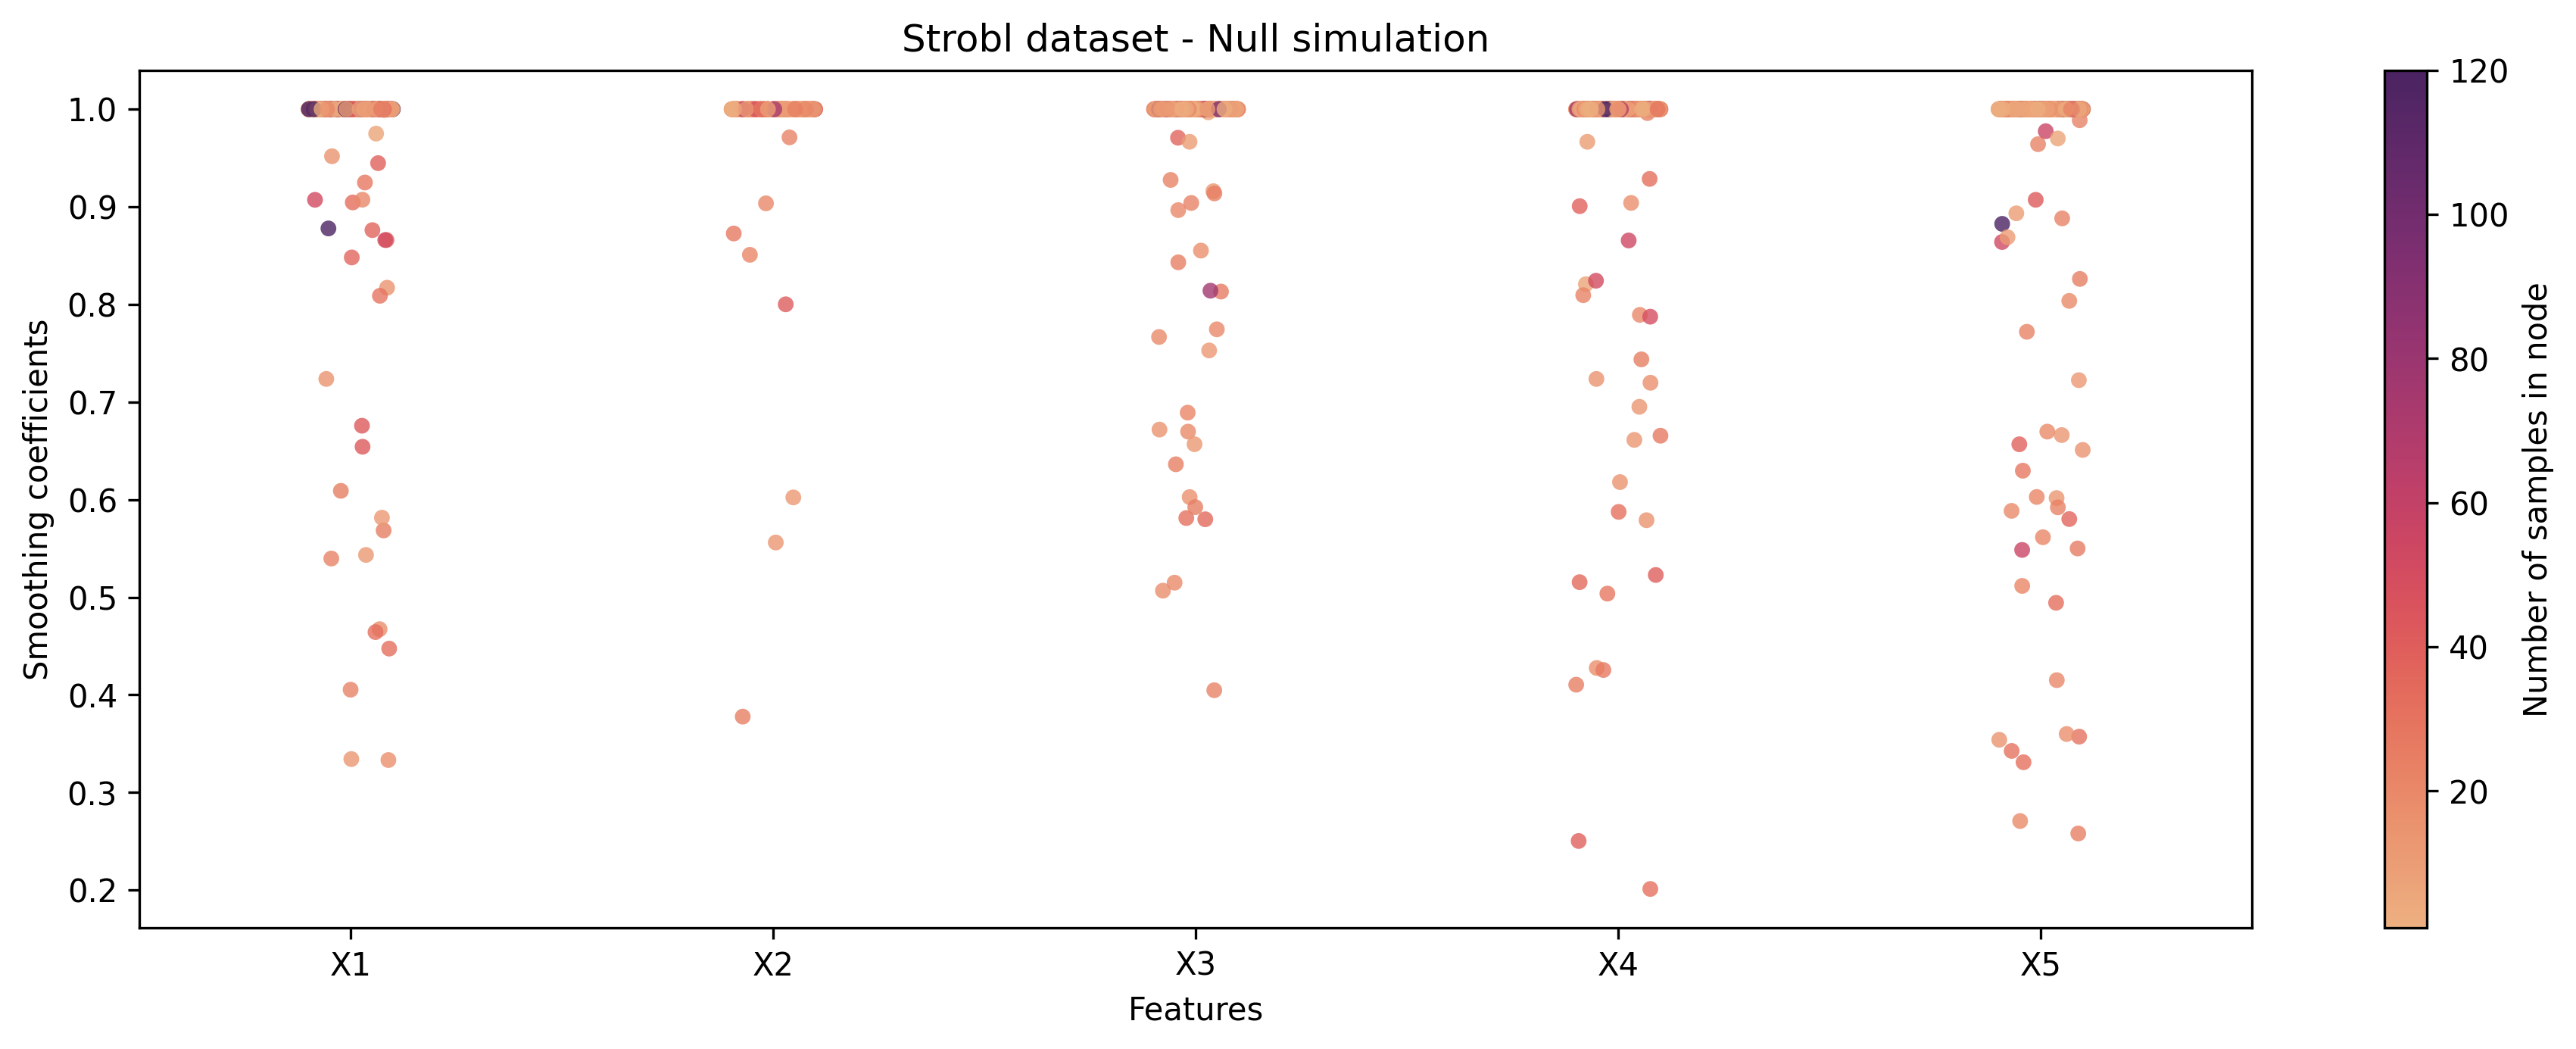

In [129]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=1, vmax=df_plot_null.samples.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_null['samples']}

t = sns.stripplot(data=df_plot_null, x='child_feature', y='m_value', hue='samples', palette=palette, alpha=0.8, ax=axs, order=[0,1,2,3,4])
t.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,6)])
axs.set_title(f"Strobl dataset - Null simulation")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Number of samples in node")  # optionally add a colorbar
plt.show()

In [130]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "strobl_null_MSEratio_coef_dist_plot_sample_size"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

##### Power case

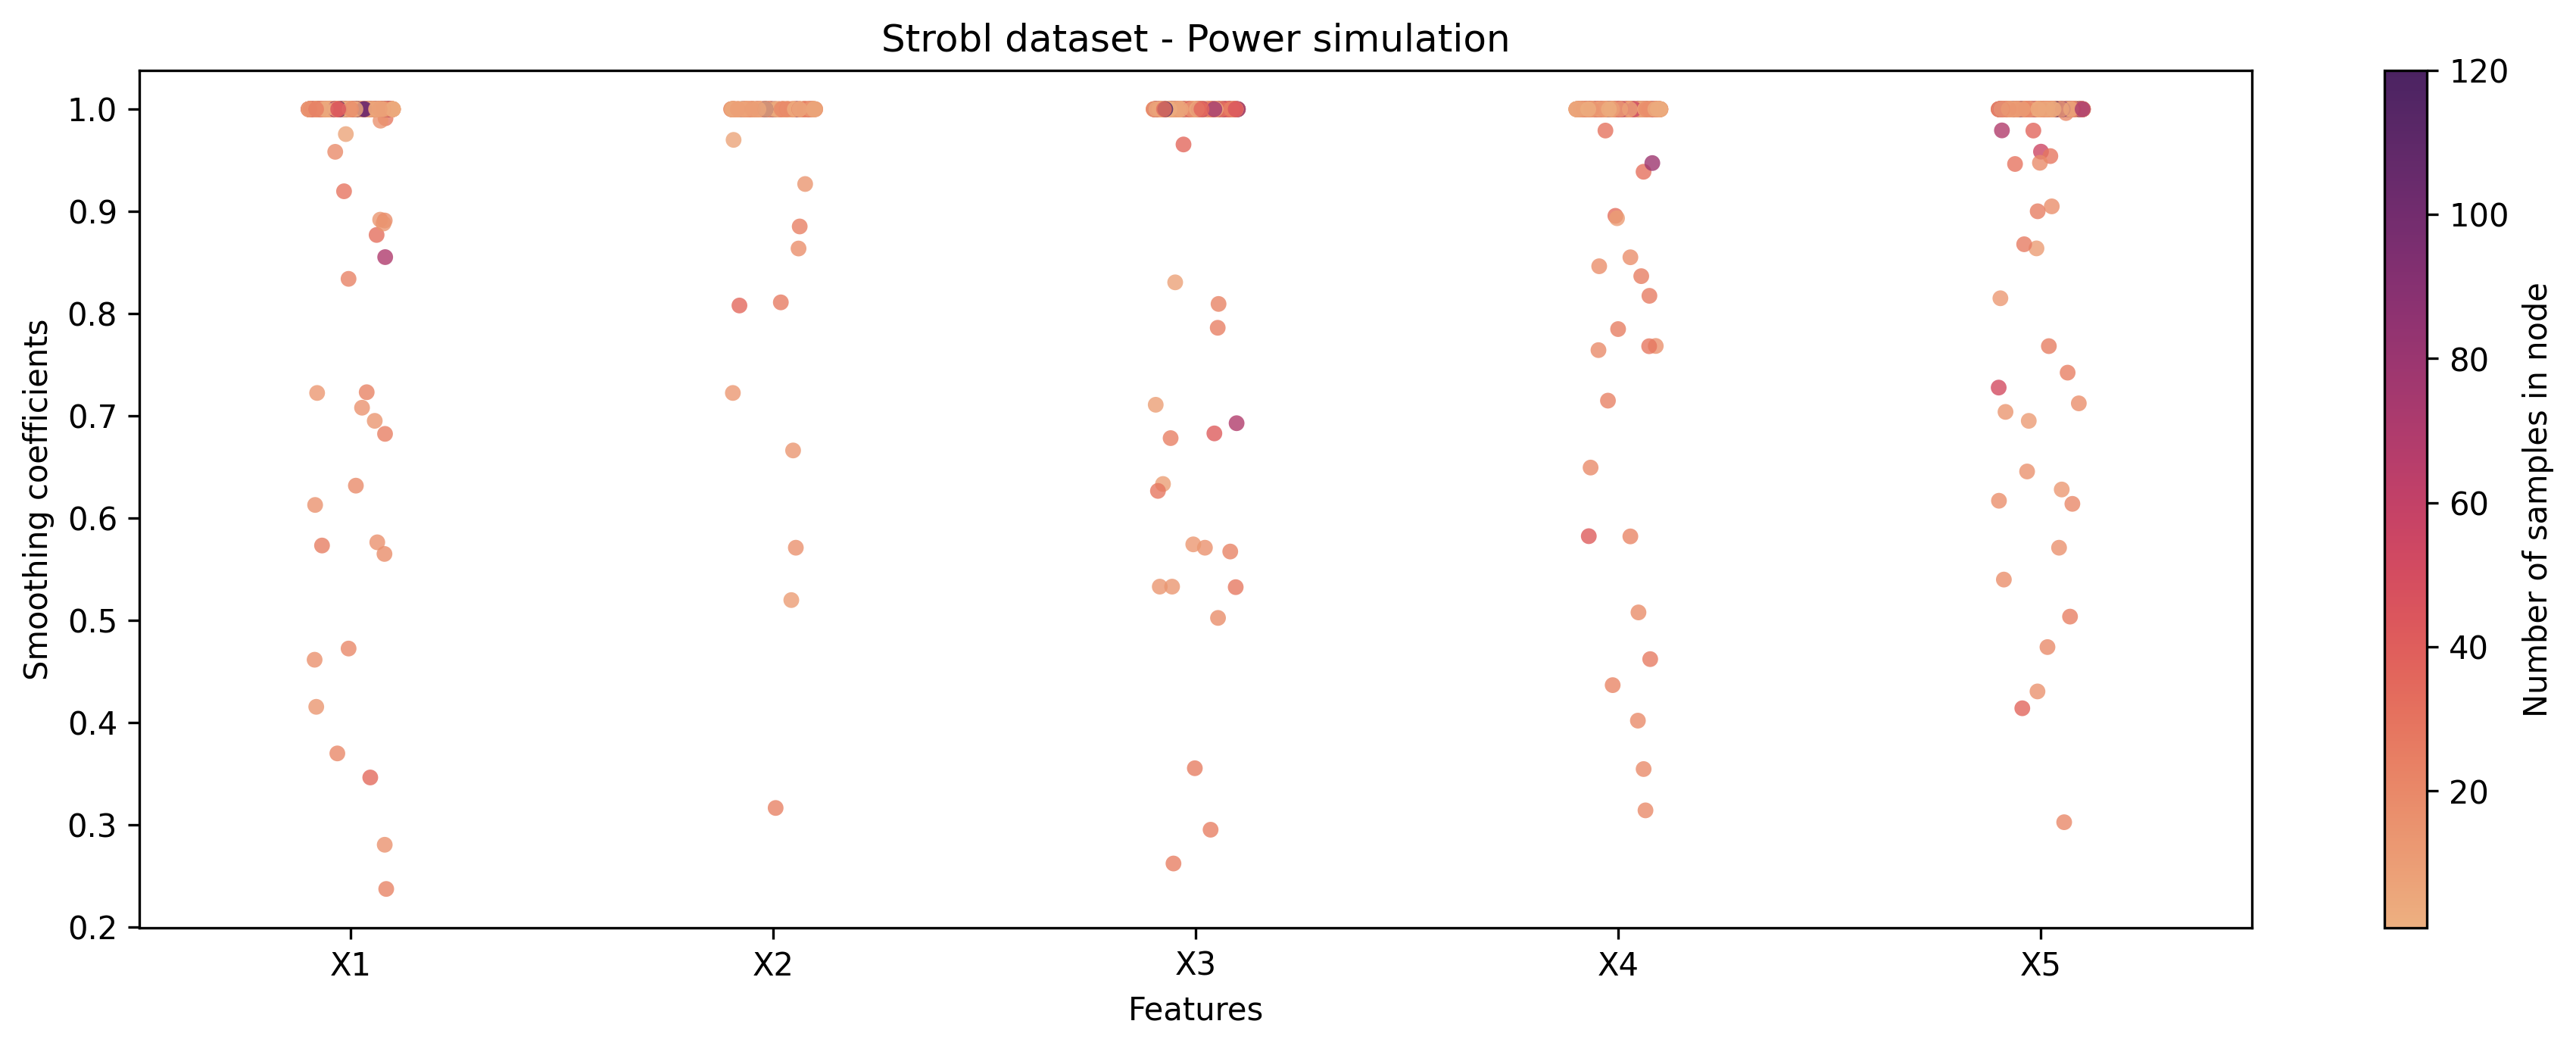

In [131]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=1, vmax=df_plot_power.samples.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_power['samples']}

t = sns.stripplot(data=df_plot_power, x='child_feature', y='m_value', hue='samples', palette=palette, alpha=0.8, ax=axs, order=[0,1,2,3,4])
t.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,6)])
axs.set_title(f"Strobl dataset - Power simulation")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Number of samples in node")  # optionally add a colorbar
plt.show()

In [132]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "strobl_power_MSEratio_coef_dist_plot_sample_size"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

#### Create plot based on node depth in tree

##### Null case

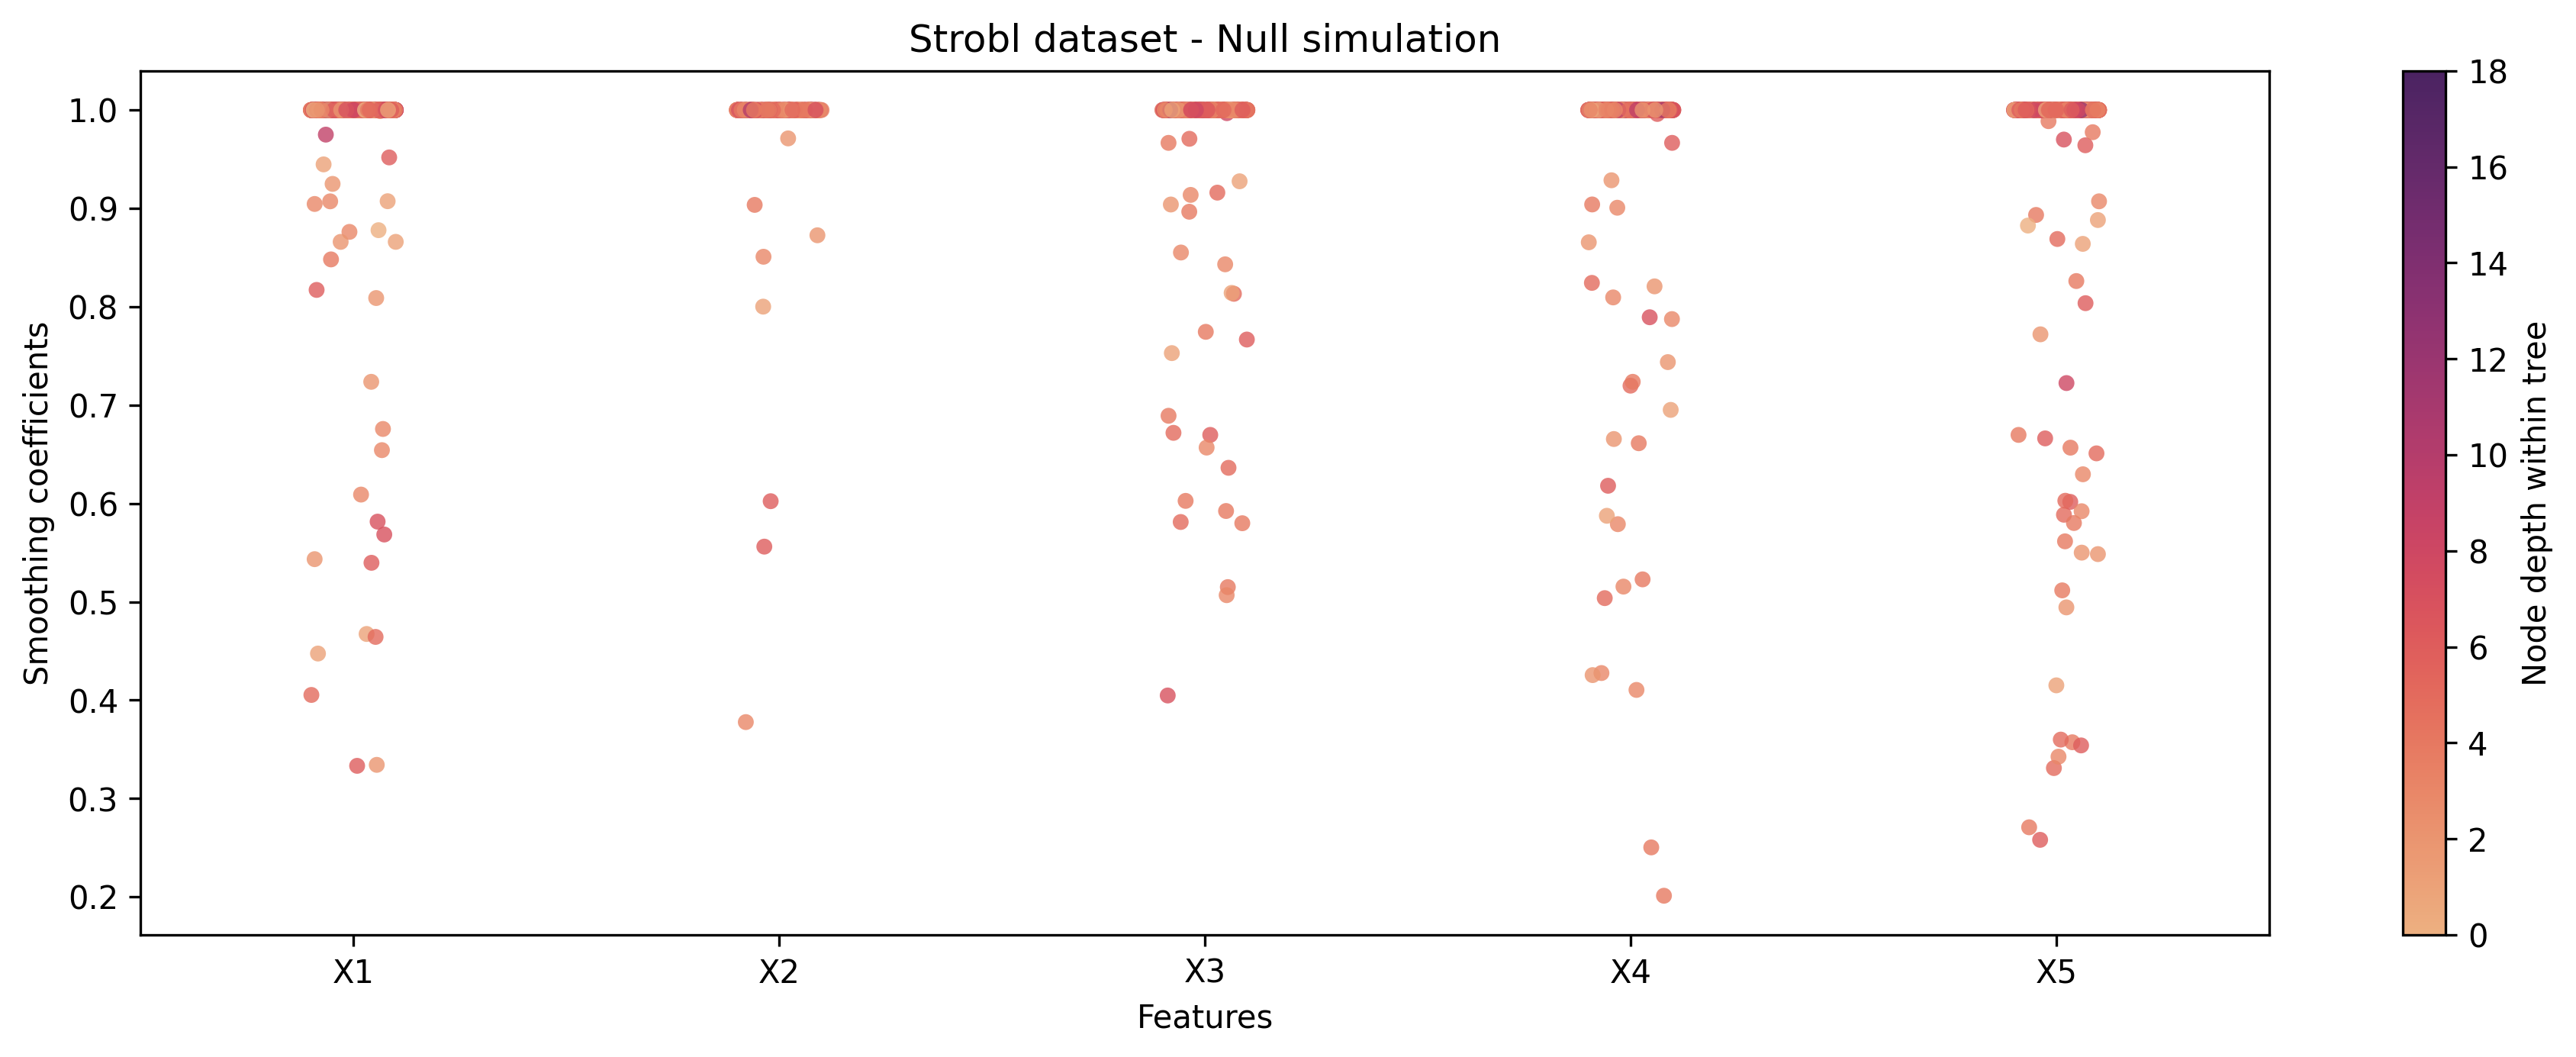

In [133]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=df_plot_null.node_depth.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_null['node_depth']}

t = sns.stripplot(data=df_plot_null, x='child_feature', y='m_value', hue='node_depth', alpha=0.8, palette=palette, ax=axs, order=[0,1,2,3,4])
t.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,6)])
axs.set_title(f"Strobl dataset - Null simulation")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Node depth within tree")  # optionally add a colorbar
plt.show()

Surprinsingly it seems that the shallower nodes show more shrinkage than deeper nodes ? 

In [134]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "strobl_null_MSEratio_coef_dist_plot_node_depth"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

##### Power case

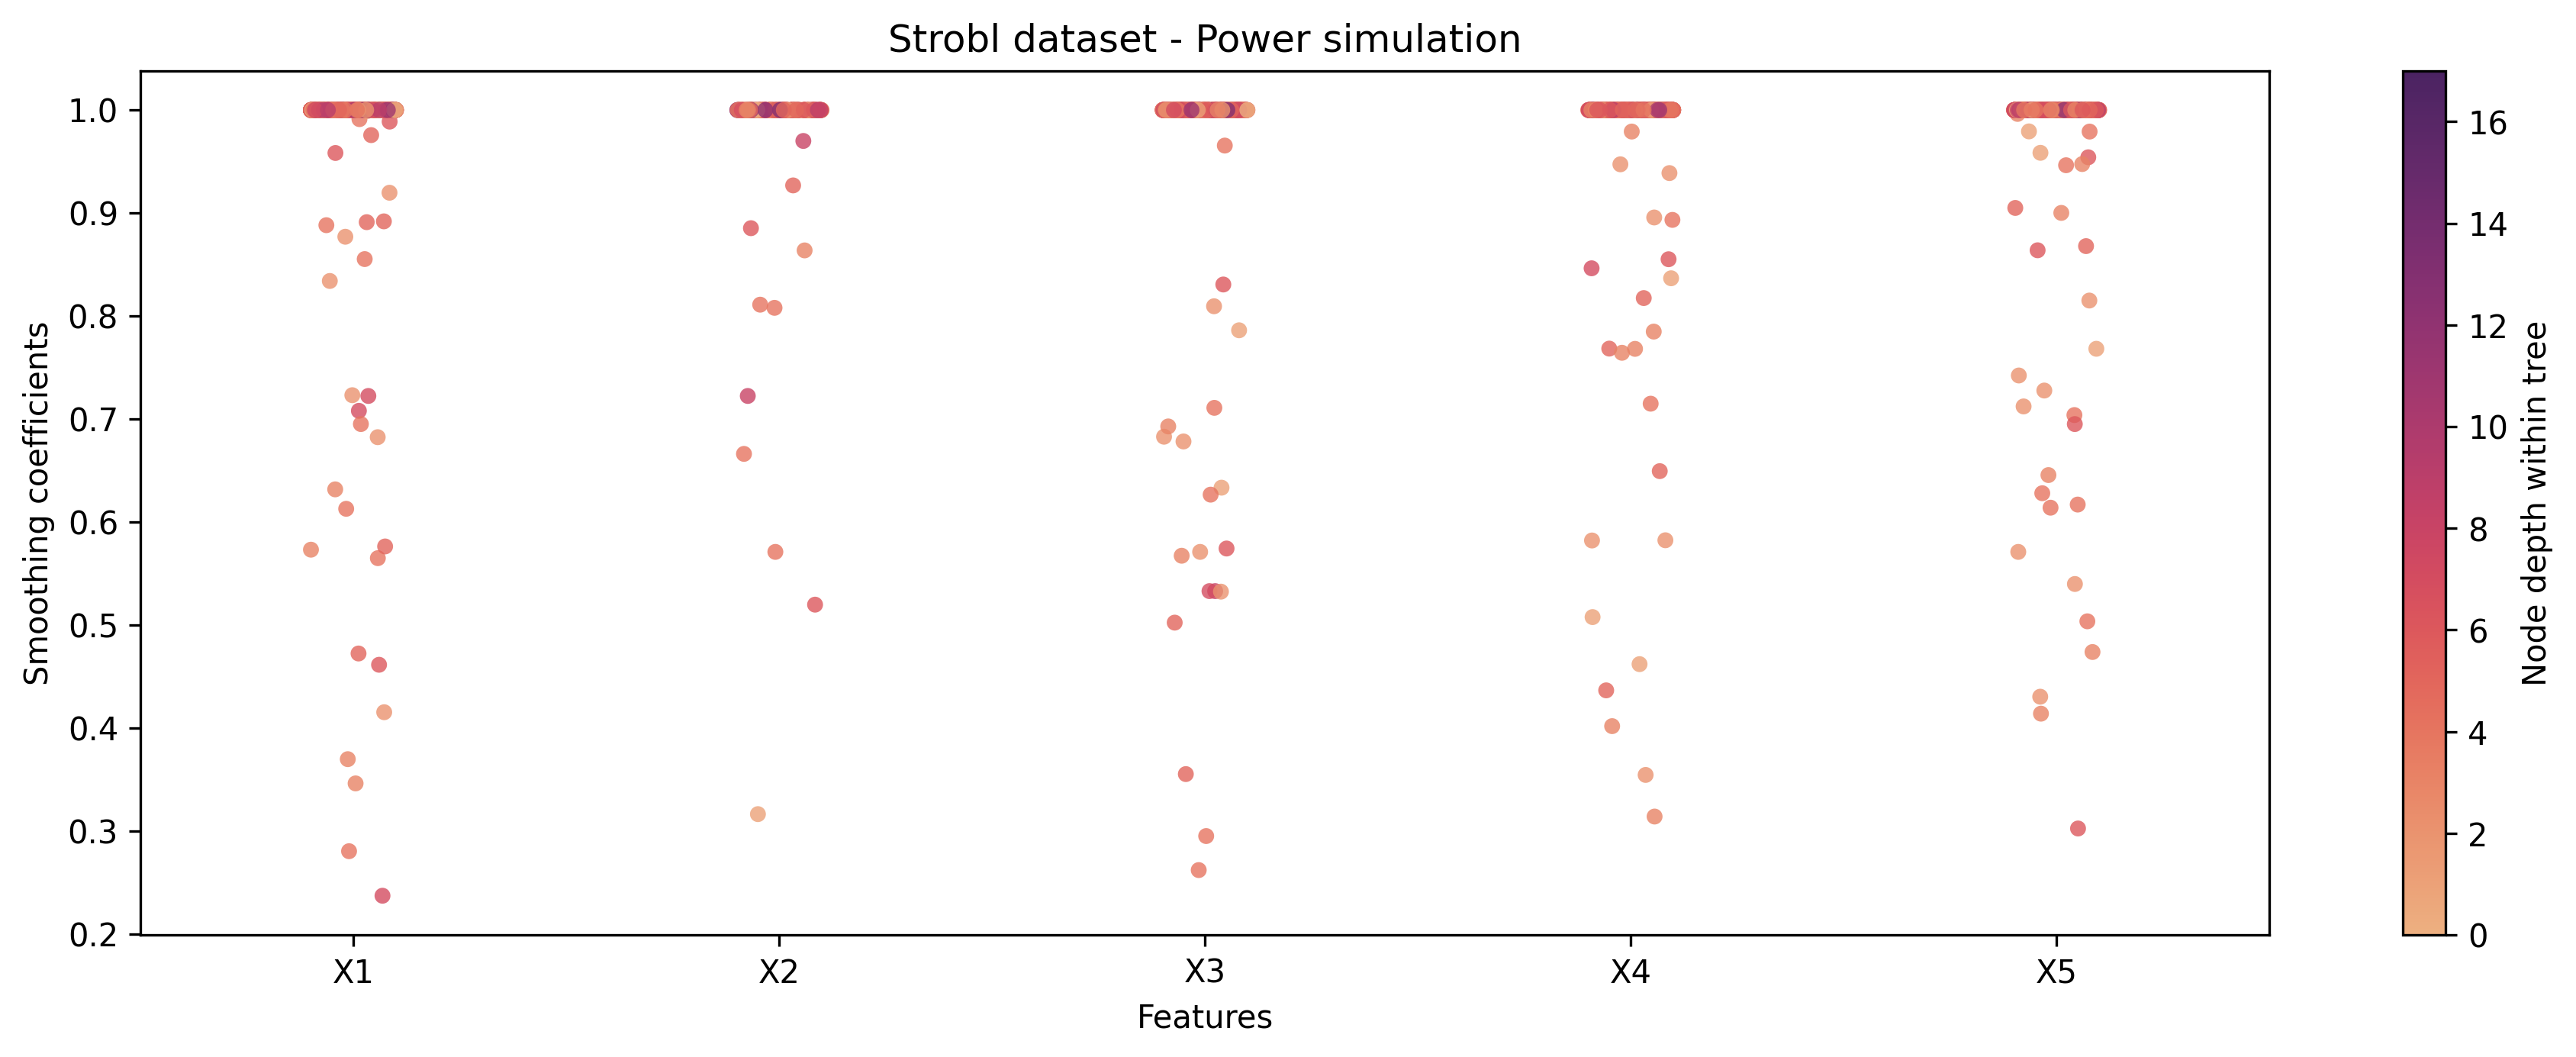

In [135]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=df_plot_power.node_depth.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_power['node_depth']}

t = sns.stripplot(data=df_plot_power, x='child_feature', y='m_value', hue='node_depth', alpha=0.8, palette=palette, ax=axs, order=[0,1,2,3,4])
t.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,6)])
axs.set_title(f"Strobl dataset - Power simulation")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Node depth within tree")  # optionally add a colorbar
plt.show()

Surprinsingly it seems that the shallower nodes show more shrinkage than deeper nodes ? 

In [136]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "strobl_null_MSEratio_coef_dist_plot_node_depth"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)